## **Function Calling LLMs - Team Project**

In [1]:
import openai
import json
import os

import pandas as pd
from pprint import pprint
from dotenv import load_dotenv


load_dotenv()
openai.api_key = os.environ.get("API_KEY")

## Data

##### Dataset 1: Most Popular Albums on Spotify

Source: https://www.kaggle.com/datasets/tobennao/rym-top-5000/

In [2]:
album_columns_to_keep = ["release_name",    # Name of the album 
                            "artist_name",     # Name of the artist/band/group
                            "release_date",    # Date the album was released
                            "primary_genres",  # Primary genre classifications
                            "secondary_genres",# Secondary genre classifications
                            "descriptors",     # Album tags
                            "avg_rating",      # Average rating, on a scale of 0-5
                            "rating_count",    # The number of ratings
                            "review_count"     # The number of reviews
                        ]

albums_popular = pd.read_csv("./data/popular_albums.csv", usecols=album_columns_to_keep)


# one attribute for release_date
def combine_and_deduplicate_genres(primary, secondary):
    combined_genres = set()

    if primary and not isinstance(primary, float):
        combined_genres.update(primary.split(', '))

    if secondary and not isinstance(secondary, float):
        combined_genres.update(secondary.split(', '))

    return ', '.join(combined_genres)


albums_popular['genres'] = albums_popular.apply(lambda row: combine_and_deduplicate_genres(
    row['primary_genres'], row['secondary_genres']), axis=1)

albums_popular.drop(['primary_genres', 'secondary_genres'], axis=1, inplace=True)


# reorder:
new_order = ["release_name", "artist_name", "release_date", "genres",
             "descriptors", "avg_rating", "rating_count", "review_count"]
albums_popular = albums_popular[new_order]

In [3]:
album_columns_to_keep = ["release_name",    # Name of the album
                         "artist_name",     # Name of the artist/band/group
                         "release_date",    # Date the album was released
                         "genres",          # Genre
                         "descriptors",     # Album tags
                         "avg_rating",      # Average rating, on a scale of 0-5
                         "rating_count",    # The number of ratings
                         "review_count"     # The number of reviews
                         ]

albums_long_tail = pd.read_csv("./data/albums_long_tail.csv", usecols=album_columns_to_keep)

In [4]:
ALBUMS = pd.concat([albums_popular[:500], albums_long_tail], ignore_index=True)

print(f"Attributes: {ALBUMS.columns.to_list()}")
print(f"Number of attributes (columns): {ALBUMS.shape[1]}")
print(f"Number of examples (rows): {ALBUMS.shape[0]}")

ALBUMS[-10:].head(n=10)

Attributes: ['release_name', 'artist_name', 'release_date', 'genres', 'descriptors', 'avg_rating', 'rating_count', 'review_count']
Number of attributes (columns): 8
Number of examples (rows): 619


,release_name,artist_name,release_date,genres,descriptors,avg_rating,rating_count,review_count
609,Dismantled Into Juice,Blawan,2023-05-17,"UK Bass, Wonky Techno, Deconstructed Club, Wonky","mechanical, rhythmic, hypnotic, dissonant, raw...",3.34,527,2.0
610,But Here We Are,Foo Fighters,2023-06-02,"Alternative Rock, Power Pop, Post-Grunge, Shoe...","death, male vocalist, melodic, anthemic, bitte...",3.56,5118,76.0
611,Metro Boomin Presents Spider-Man: Across the S...,Metro Boomin,2023-06-02,"Film Soundtrack, Pop Rap, Trap, Afrobeats, Con...","male vocalist, female vocalist, optimistic, tr...",2.96,2295,19.0
612,Formal Growth in the Desert,Protomartyr,2023-06-02,"Post-Punk, Art Punk, Gothic Rock, Noise Rock","male vocalist, dark, rhythmic, atmospheric, de...",3.45,2785,29.0
613,Bunny,Beach Fossils,2023-06-02,"Jangle Pop, Indie Pop, Dream Pop, Indie Surf, ...","male vocalist, mellow, calm, soft, ethereal, w...",3.29,929,9.0
614,Everyone's Crushed,Water From Your Eyes,2023-05-26,"Experimental Rock, Art Pop, Neo-Psychedelia, P...","apathetic, urban, dissonant, noisy, energetic,...",3.32,1149,15.0
615,Aperture,Hannah Jadagu,2023-05-19,"Indie Pop, Dream Pop, Bedroom Pop","bittersweet, melancholic, sentimental, energet...",3.44,293,4.0
616,More Photographs (A Continuum),Kevin Morby,2023-05-26,"Folk Rock, Singer-Songwriter, Indie Folk, Amer...","lonely, sentimental, melodic, male vocalist, w...",3.13,143,2.0
617,Perfume,NCT DOJAEJUNG,2023-04-17,"Contemporary R&B, K-Pop, Dance-Pop, Future Bas...","sensual, male vocalist, melodic, rhythmic, rom...",3.44,360,3.0
618,AESTHETIC,tripleS / +(KR)ystal Eyes,2023-05-04,"K-Pop, Dance-Pop, Contemporary R&B, New Jack S...","female vocalist, warm, rhythmic, lush, melodic...",3.50,752,5.0


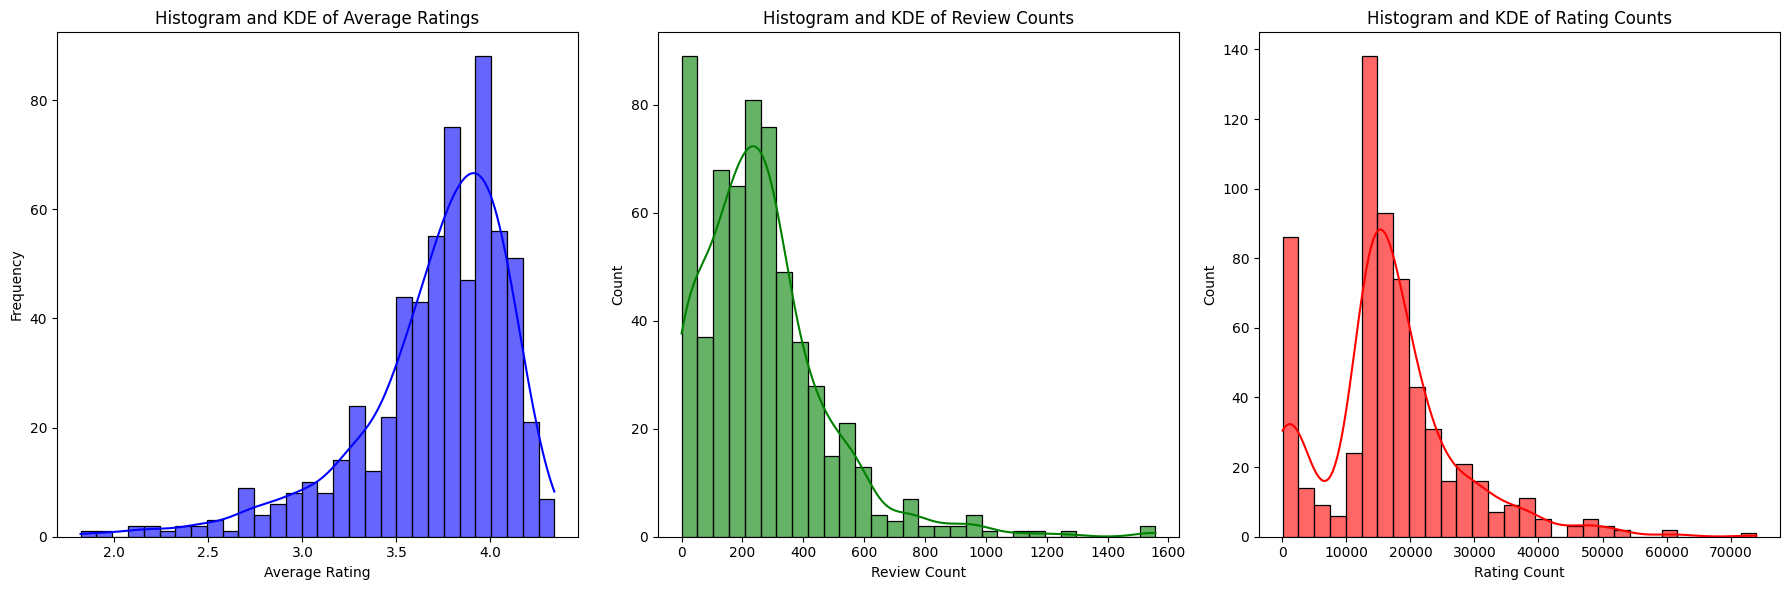

In [5]:
# Descriptive Analysis
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

sns.histplot(ALBUMS['avg_rating'], kde=True, bins=30,
             color='blue', alpha=0.6, ax=axes[0])
axes[0].set_title('Histogram and KDE of Average Ratings')
axes[0].set_xlabel('Average Rating')
axes[0].set_ylabel('Frequency')

# Histogram and KDE for Review Count
sns.histplot(ALBUMS['review_count'], kde=True, bins=30,
             color='green', alpha=0.6, ax=axes[1])
axes[1].set_title('Histogram and KDE of Review Counts')
axes[1].set_xlabel('Review Count')

# Histogram and KDE for Rating Count
sns.histplot(ALBUMS['rating_count'], kde=True, bins=30,
             color='red', alpha=0.6, ax=axes[2])
axes[2].set_title('Histogram and KDE of Rating Counts')
axes[2].set_xlabel('Rating Count')

plt.tight_layout()
plt.show()

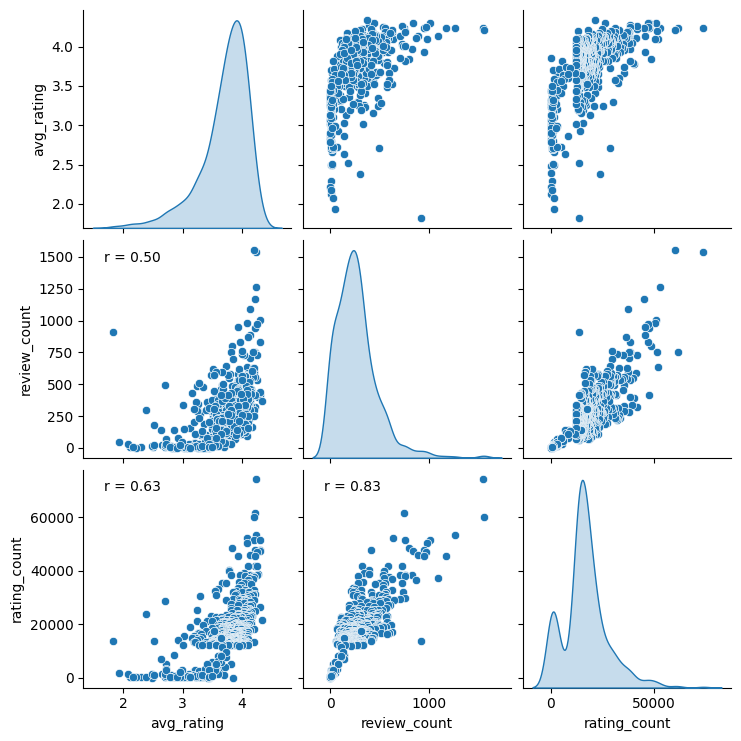

In [6]:
def corrfunc(x, y, ax=None, **kws):
    x_no_nan = x[~np.isnan(x) & ~np.isnan(y)]
    y_no_nan = y[~np.isnan(x) & ~np.isnan(y)]

    r = np.corrcoef(x_no_nan, y_no_nan)[0][1]
    ax = ax or plt.gca()
    ax.annotate(f'r = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)


g = sns.pairplot(
    ALBUMS[['avg_rating', 'review_count', 'rating_count']], diag_kind='kde')
g.map_lower(corrfunc)
plt.show()

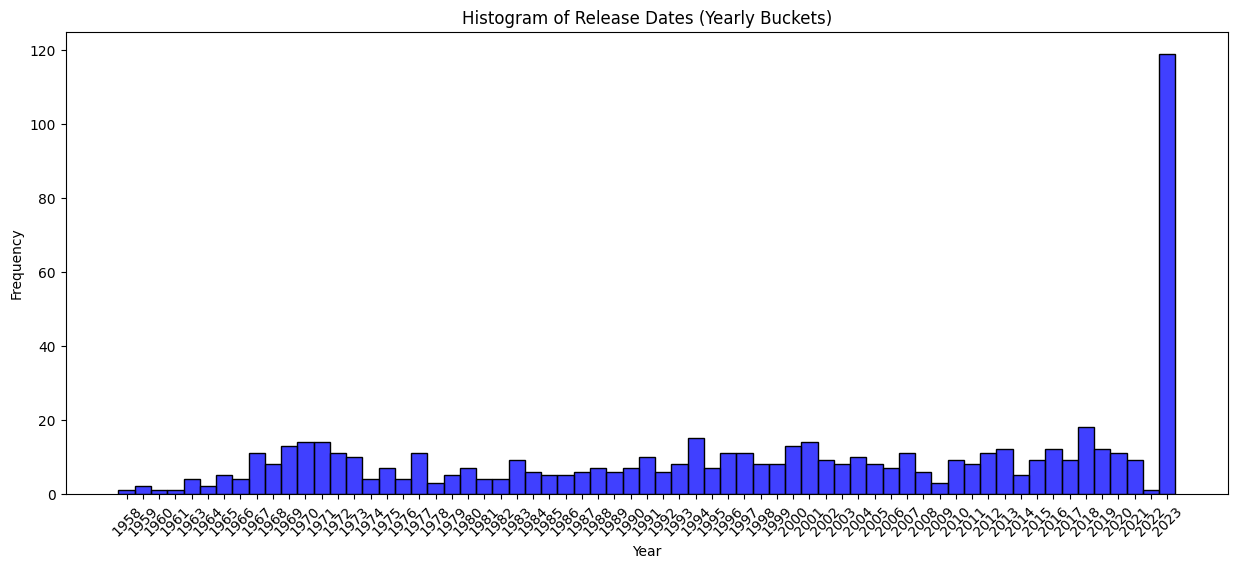

In [7]:
df_dates = pd.DataFrame()
df_dates['year'] = pd.to_datetime(ALBUMS['release_date']).dt.to_period('Y')

df_dates = df_dates.sort_values(by='year')

plt.figure(figsize=(15, 6))
sns.histplot(df_dates['year'].astype(str), bins=20, color='blue')
plt.xticks(rotation=45)
plt.title('Histogram of Release Dates (Yearly Buckets)')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

##### Dataset 2: Most Streamed Tracks on Spotify

Source: https://www.kaggle.com/datasets/nelgiriyewithana/top-spotify-songs-2023

In [8]:
song_columns_to_keep = ['track_name',           # Name of the song
                        'artist(s)_name',       # Name of the artist(s) of the song
                        'artist_count',         # Number of artists contributing to the song
                        'released_year',        # Year when the song was released
                        'released_month',       # Month when the song was released
                        'released_day',         # Day of the month when the song was released
                        'streams',              # Total number of streams on Spotify
                        'bpm',                  # Beats per minute, a measure of song tempo
                        'key',                  # Key of the song
                        'mode',                 # Mode of the song (major or minor)
                        'danceability_%',       # Percentage indicating how suitable the song is for dancing
                        'valence_%',            # Positivity of the song's musical content
                        'energy_%',             # Perceived energy level of the song
                        'acousticness_%',       # Amount of acoustic sound in the song
                        'instrumentalness_%',   # Amount of instrumental content in the song
                        'liveness_%',           # Presence of live performance elements
                        'speechiness_%'         # Amount of spoken words in the song
                        ]


songs_short_tail = pd.read_csv("./data/tracks.csv", encoding_errors="ignore")

# one attribute for release_date
songs_short_tail['release_date'] = pd.to_datetime(songs_short_tail['released_year'].astype(str) + '-' +
                                       songs_short_tail['released_month'].astype(str) + '-' +
                                       songs_short_tail['released_day'].astype(str))

songs_short_tail.drop(['released_year', 'released_month',
        'released_day'], axis=1, inplace=True)


songs_short_tail['release_date'] = songs_short_tail['release_date'].apply(
    lambda x: str(x).replace(" 00:00:00", "") if "00:00:00" in str(x) else x)

# reorder:
new_order = ['track_name', 'artist(s)_name', 'artist_count', 'release_date', 'streams', 'bpm', 'key', 'mode', 
             'danceability_%', 'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%']
songs_short_tail = songs_short_tail[new_order]

In [9]:
songs_long_tail = pd.read_csv("./data/tracks_long_tail.csv", encoding_errors="ignore")

In [10]:
SONGS = pd.concat([songs_short_tail[:500], songs_long_tail], ignore_index=True)

print(f"Attributes: {SONGS.columns.to_list()}")
print(f"Number of attributes (columns): {SONGS.shape[1]}")
print(f"Number of examples (rows): {SONGS.shape[0]}")

SONGS[495:].head(n=10)

Attributes: ['track_name', 'artist(s)_name', 'artist_count', 'release_date', 'streams', 'bpm', 'key', 'mode', 'danceability_%', 'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%', 'album', 'explicit', 'popularity', 'duration_in_min']
Number of attributes (columns): 19
Number of examples (rows): 960


,track_name,artist(s)_name,artist_count,release_date,streams,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,album,explicit,popularity,duration_in_min
495,Run Rudolph Run - Single Version,Chuck Berry,1,1958-01-01,245350949,152,G,Minor,69,94,71,79,0,7,8,NaN,NaN,NaN,NaN
496,Jingle Bells - Remastered 1999,Frank Sinatra,1,1957-01-01,178660459,175,G#,Major,51,94,34,73,0,10,5,NaN,NaN,NaN,NaN
497,Far,SZA,1,2022-12-09,51641685,116,D,Major,61,48,55,67,0,16,8,NaN,NaN,NaN,NaN
498,On Time (with John Legend),"John Legend, Metro Boomin",2,2022-12-02,78139948,80,F,Minor,33,51,59,76,0,44,6,NaN,NaN,NaN,NaN
499,GAT��,"Maldy, Karol G",2,2022-08-25,322336177,93,B,Minor,63,34,86,26,0,21,39,NaN,NaN,NaN,NaN
500,3D (feat. Jack Harlow),"Jung Kook, Jack Harlow",2,2023-11-03,NaN,108,C#,Major,86,89,83,4,0,9,11,GOLDEN,True,85.0,3.363533
501,Closer to You (feat. Major Lazer),"Jung Kook, Major Lazer",2,2023-11-03,NaN,113,D,Minor,79,50,66,12,1,11,5,GOLDEN,False,86.0,2.849917
502,Seven (feat. Latto) (Explicit Ver.),"Jung Kook, Latto",2,2023-11-03,NaN,124,B,Major,79,88,84,32,0,8,5,GOLDEN,True,87.0,3.059183
503,Standing Next to You,Jung Kook,1,2023-11-03,NaN,106,D,Minor,72,82,81,5,0,34,10,GOLDEN,False,96.0,3.433667
504,Yes or No,Jung Kook,1,2023-11-03,NaN,83,C#,Major,68,89,84,18,0,8,9,GOLDEN,False,88.0,2.459283


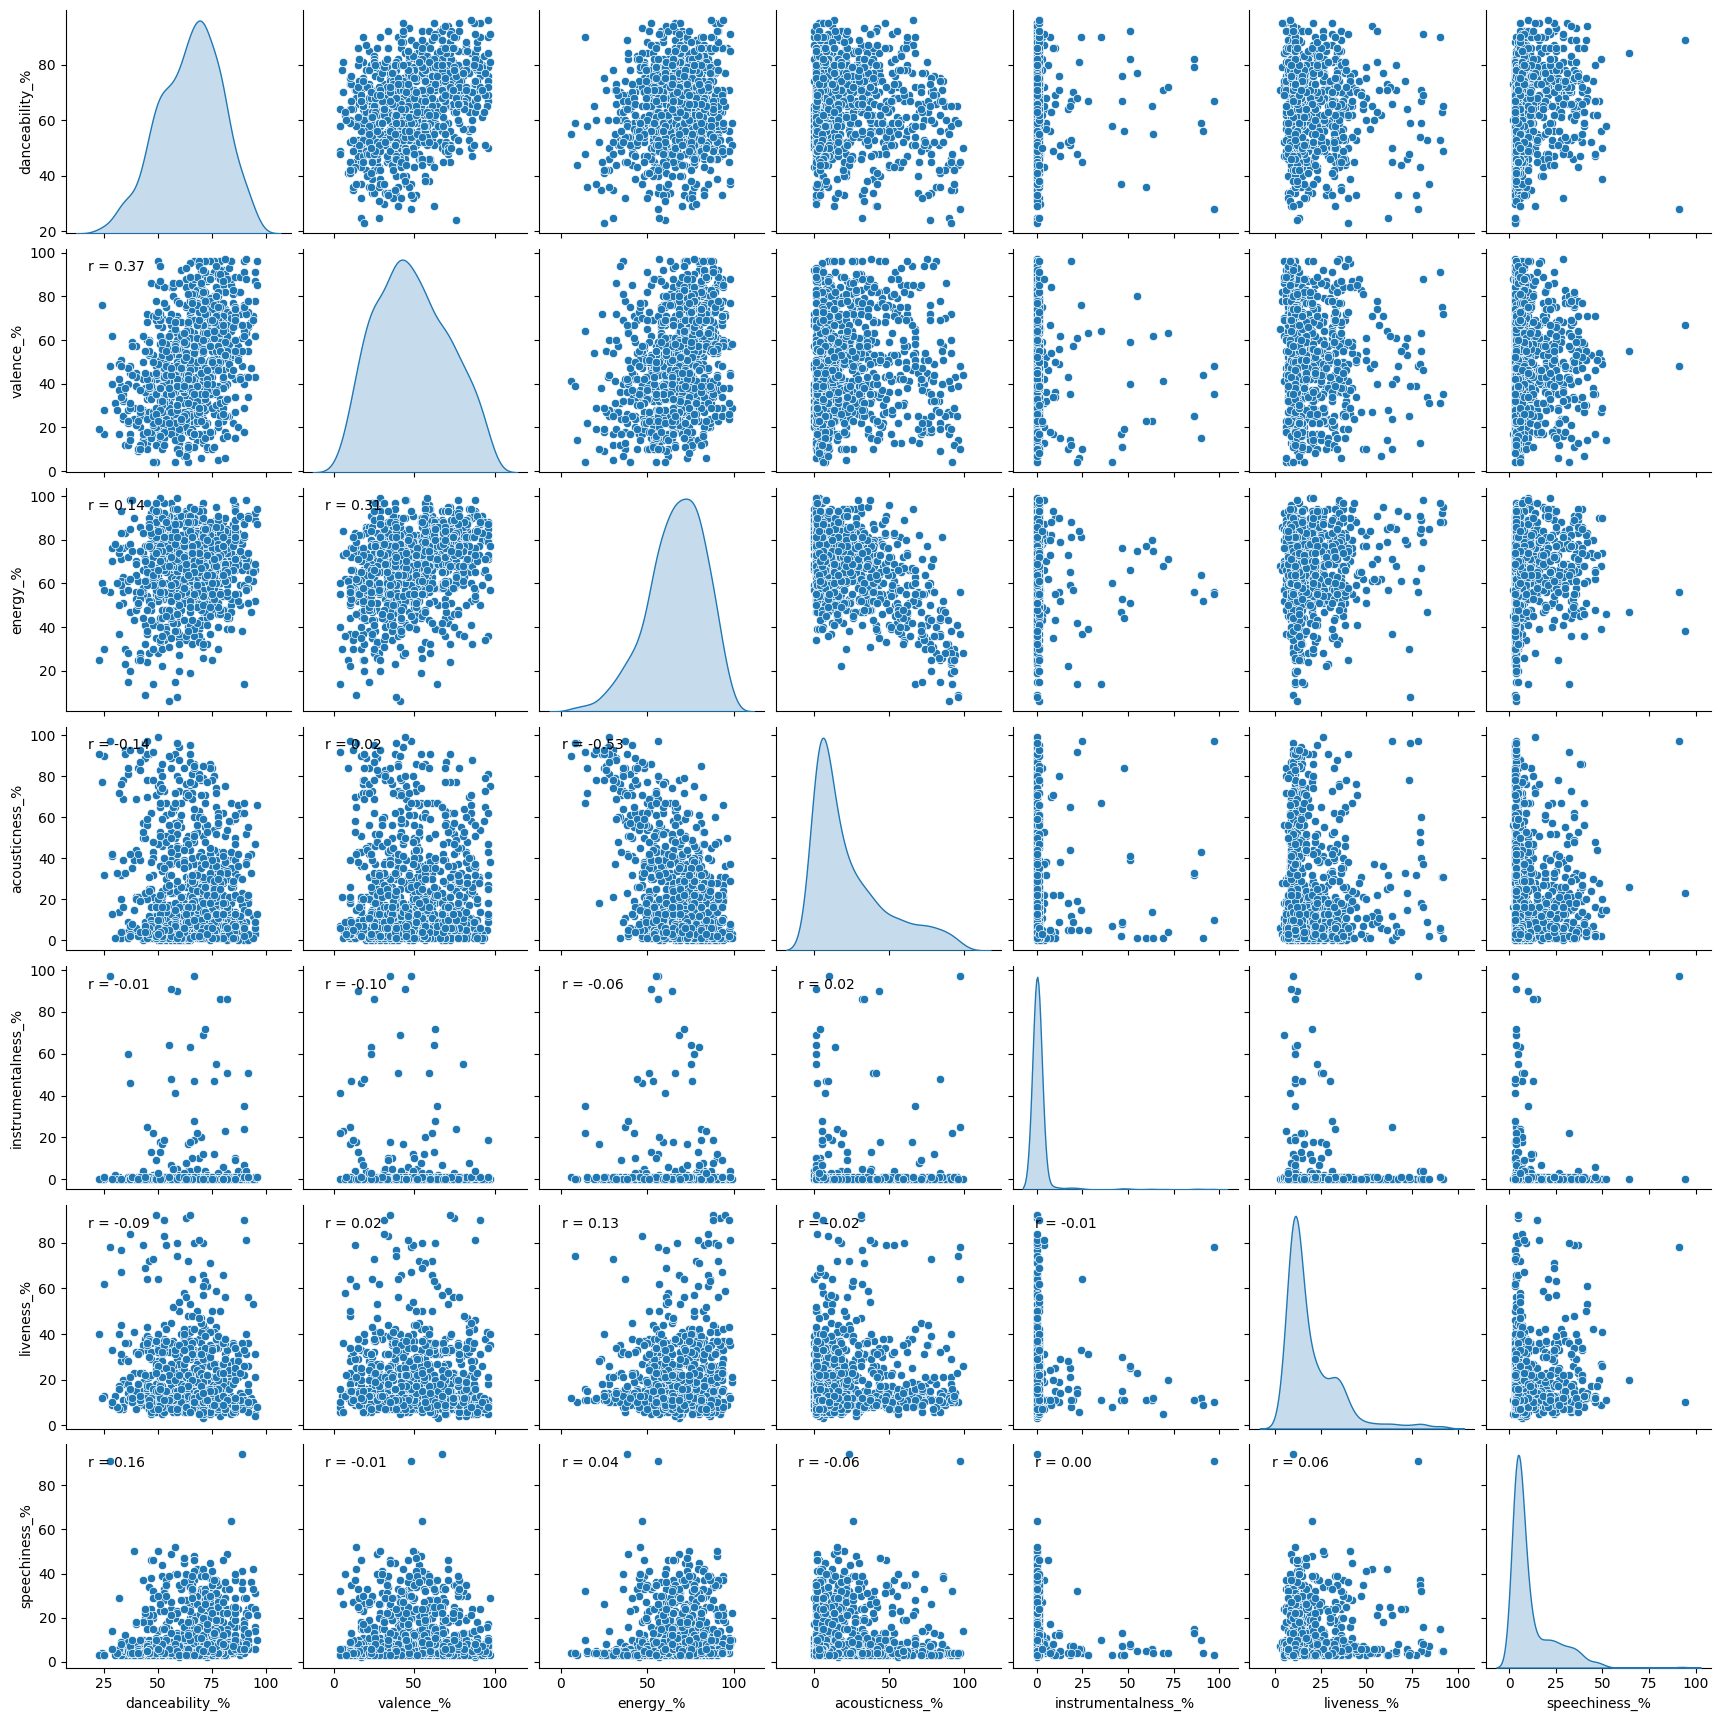

In [11]:
# Descriptive Statistics
SONGS.describe()


def corrfunc(x, y, ax=None, **kws):
    x_no_nan = x[~np.isnan(x) & ~np.isnan(y)]
    y_no_nan = y[~np.isnan(x) & ~np.isnan(y)]

    r = np.corrcoef(x_no_nan, y_no_nan)[0][1]
    ax = ax or plt.gca()
    ax.annotate(f'r = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)


g = sns.pairplot(
    SONGS[['danceability_%', 'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%']], diag_kind='kde')
g.map_lower(corrfunc)
plt.show()

## Functions

#### Albums

In [12]:
def top_rated_albums(n=10):
    """
    Returns the top-rated albums based on average rating.
    
    Parameters:
        n (int): The number of albums to return. Default is 10.
    
    Returns:
        list[dict]: A list of dictionaries representing the top-rated albums.
    """
    top_rated = ALBUMS.sort_values(by='avg_rating', ascending=False).head(n)
    return top_rated.to_dict(orient='records')

def most_reviewed_albums(n=10):
    """
    Returns the most reviewed albums.
    
    Parameters:
        n (int): The number of albums to return. Default is 10.
    
    Returns:
        list[dict]: A list of dictionaries representing the most reviewed albums.
    """
    most_reviewed = ALBUMS.sort_values(by='review_count', ascending=False).head(n)
    return most_reviewed.to_dict(orient='records')
    
def albums_by_artist(artist_name):
    """
    Returns all albums by a given artist.
    
    Parameters:
        artist_name (str): The name of the artist.
    
    Returns:
        list[dict]: A list of dictionaries representing the albums by the given artist.
    """
    albums = ALBUMS[ALBUMS['artist_name'] == artist_name]
    return albums.to_dict(orient='records')

def artist_by_album(album_name):
    """
    Returns the artist of an album by its name.

    Parameters:
        album_name (str): The name of the album.

    Returns:
        dict: A dictionary with the album name and the artist.
              If the album is not found, the dictionary will be empty.
    """
    
    artist_dict = {}
    
    # Search for the album by name and populate the dictionary
    album = ALBUMS[ALBUMS['release_name'] == album_name]
    if not album.empty:
        artist_dict['Album name'] = album_name
        artist_dict['artist'] = album.iloc[0]['artist_name']
    
    return artist_dict


In [13]:
def albums_by_release_date(date_str):
    """
    Returns all albums that have the same date as the provided date.
    The function accepts dates in 'YYYY', 'YYYY-MM', or 'YYYY-MM-DD' format.

    Parameters:
        date_str (str): The date in 'YYYY', 'YYYY-MM', or 'YYYY-MM-DD' format.

    Returns:
        DataFrame: A DataFrame containing all records from the same year.
                   If no records are found for that year, it returns an empty DataFrame.
    """
    year = int(date_str[:4])

    records_in_year = ALBUMS[pd.to_datetime(
        ALBUMS['release_date']).dt.year == year]
    
    records_dict = records_in_year.to_dict(orient='records')
    return records_dict

#### Songs

In [14]:
def top_streamed_songs(n=10):
    """
    Returns the top-streamed songs.
    
    Parameters:
        n (int): The number of songs to return. Default is 10.
    
    Returns:
        list[dict]: A list of dictionaries representing the top-streamed songs.
    """
    top_songs = SONGS.sort_values(by='streams', ascending=False).head(n)
    return top_songs.to_dict(orient='records')

def songs_by_artist(artist_name):
    """
    Returns all songs by a given artist.
    
    Parameters:
        artist_name (str): The name of the artist.
    
    Returns:
        list[dict]: A list of dictionaries representing the songs by the given artist.
    """
    songs = SONGS[SONGS['artist(s)_name'] == artist_name]
    return songs.to_dict(orient='records')

def artist_by_song(song_name):
    """
    Returns the artist of the song.

    Parameters:
        song_name (str): The name of the song.

    Returns:
        dict: A dictionary with the song name and the artist.
              If the song is not found, the dictionary will be empty.
    """
    
    artist_dict = {}
    
    # Search for the song by name and populate the dictionary
    song = SONGS[SONGS['track_name'] == song_name]
    if not song.empty:
        artist_dict['Song'] = song_name
        artist_dict['Artist'] = song.iloc[0]['artist(s)_name']
    
    return artist_dict

In [15]:
def songs_by_longest_duration(n=10):
    """
    Returns the top n songs sorted by longest duration.
    
    Parameters:
        n (int): The number of top songs to return based on duration.
    
    Returns:
        list[dict]: A list of dictionaries representing the top n songs sorted by duration.
    """    
    sorted_songs = SONGS.sort_values(by="duration_in_min", ascending=False)
    top_n_songs = sorted_songs.head(n)
    return top_n_songs.to_dict(orient='records')

#### Metadata

In [16]:
def filter_functions(functions_list, function_metadata):
    function_names = [func.__name__ for func in functions_list]
    filtered_metadata = [meta for meta in function_metadata if meta.get('name') in function_names]
    return functions_list, filtered_metadata

def describe_function(available_functions):
    return [meta["description"] for meta in available_functions[1]]

## LLM

In [17]:
from enum import Enum
from openai.openai_object import OpenAIObject

class Role(Enum):
    ASSISTANT = "assistant"
    FUNCTION = "function"
    SYSTEM = "system"
    USER = "user"
    
class Model(Enum):
    GPT3 = "gpt-3.5-turbo-0613"
    GPT4 = "gpt-4-0613"
    GPT4_new = "gpt-4-1106-preview"

class FunctionNotFoundError(Exception):
    def __init__(self, function_name, function_args):
        self.function_name = function_name
        self.function_args = function_args
        super().__init__(f"Error finding function {function_name} with arguments {function_args}")

class FunctionExecutionError(Exception):
    def __init__(self, function_name, function_args):
        self.function_name = function_name
        self.function_args = function_args
        super().__init__(f"Error executing function {function_name} with arguments {function_args}")


class Response:
    def __init__(self, message:dict):
        self._message = message
        
    @classmethod
    def from_api(cls, openai_response:OpenAIObject):
        _message = openai_response["choices"][0]["message"]
        return cls(_message)
    
    @property
    def message(self) -> str:
        return self._message["content"]

    @property
    def role(self) -> str:
        return self._message["role"]

    @property
    def function(self) -> dict:
        return self._message.get("function_call")

    @property
    def is_function_call(self) -> bool:
        return self.function is not None
    
    def to_dict(self) -> dict:
        return {**self._message}
    
    def __str__(self):
        return f"Response({self.role}: {self.message}, with function:{self.function})"


class Conversation:
    def __init__(self):
        self._messages = []

    @property
    def messages_as_dicts(self):
        return [message.to_dict() for message in self._messages]

    def send(self, model, functions) -> Response:

        args = {"model":model, 
                "messages":self.messages_as_dicts}
        
        if len(functions) > 0:
            args.update({"function_call":"auto",
                         "functions":functions})
            
        response = openai.ChatCompletion.create(**args)
        return Response.from_api(response)

    def add(self, message_or_response):
        if isinstance(message_or_response, Response):
            message = message_or_response
        else:
            message = Response(message_or_response)

        self._messages.append(message)        
        return self
    
    def __str__(self):
        return f"{self.messages_as_dicts}"
    

def handle_function(function:dict, functions) -> json:
    """Invoke function and return result"""
    function_name, function_args = function["name"], json.loads(function["arguments"])
    
    def get_function_by_name():
        for func in functions:
            if func.__name__ == function_name:
                return func
        return None
    
    function_to_call = get_function_by_name()
    if function_to_call is not None:
        try:
            result = json.dumps(function_to_call(**function_args))
            return result
        except:
            raise FunctionExecutionError(function_name, function_args)
    else:
        raise FunctionNotFoundError(function_name, function_args)


# TODO
def handle_error(error, retry):
    raise error


max_iterations = 5
def chat(conversation:Conversation, model:str, functions:tuple) -> str:
    iteration = 0
    while iteration < max_iterations:
        iteration +=1
        response = conversation.send(model, functions[1])
        conversation.add(response)
        
        if response.is_function_call:
            try:
                result = handle_function(response.function, functions[0])
                conversation.add({"role": Role.FUNCTION.value, "content": result, "name":response.function["name"]})
            except (FunctionNotFoundError, FunctionExecutionError) as error:
                handle_error(error=error, retry=False)
        else:
            return response.message
        

def handle_function_on_server(function):
    function_name, function_args = function["name"], json.loads(
        function["arguments"])
    
    import requests
    
    URL = f"http://localhost:5000/function_call/{function_name}?"
    
    response = requests.get(URL, params=function_args)
    if response.ok:
        data = response.json()
        return data["result"]
    else:
        raise FunctionExecutionError # TODO
    
    

PORT = 5000
def chat_web(conversation: Conversation, model: str, function_metadata: list) -> str:
    iteration = 0
    while iteration < max_iterations:
        iteration += 1
        response = conversation.send(model, function_metadata)
        conversation.add(response)

        if response.is_function_call:
            try:
                result = handle_function_on_server(response.function)
                conversation.add(
                    {"role": Role.FUNCTION.value, "content": result, "name": response.function["name"]})
            except (FunctionNotFoundError, FunctionExecutionError) as error:
                handle_error(error=error, retry=False)
        else:
            return response.message

## Benchmark

In [18]:
# all_functions = [top_rated_albums, most_reviewed_albums, albums_by_artist, top_streamed_songs, songs_in_spotify_playlists, songs_by_artist, artist_by_song, artist_by_album]
all_functions = [top_rated_albums, top_streamed_songs, songs_by_artist, songs_by_longest_duration, albums_by_artist, albums_by_release_date]

with open('functions.json', 'r') as file:

    function_metadata = json.load(file)

In [19]:
print("Functions: " + str(len(all_functions)))
print(all_functions)

print()
print("Metadata: " + str(len(function_metadata)))
for meta_data in function_metadata:
    print(f"{meta_data['name']}: {meta_data['description']}")

Functions: 6
[<function top_rated_albums at 0x00000198DFEC0EA0>, <function top_streamed_songs at 0x00000198A844F4C0>, <function songs_by_artist at 0x00000198A844FEC0>, <function songs_by_longest_duration at 0x00000198C0B53B00>, <function albums_by_artist at 0x00000198E29FFF60>, <function albums_by_release_date at 0x00000198DF7AF7E0>]

Metadata: 10
top_rated_albums: Retrieves the records that have been valued uppermost. Includes information like genres and descriptors and ratings.
most_reviewed_albums: Fetches the records that have been reviewed most frequently.
albums_by_artist: Gets albums of specified singer.
top_streamed_songs: Returns the top n streamed song records. Records contain information about artists, song ratings like the number of ratings for each song, and some more song specific details.
songs_in_spotify_playlists: Retrieves the top-added musical pieces in Spotify playlists.
songs_by_artist: Fetches the music recording that has been released by the singer.
artist_by_son

#### Functions

##### Start

In [26]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "How many albums were released in 1970?"})

result = chat(conversation, model=Model.GPT3.value, functions=available_functions)
print(result) #* CORRECT (but was 13 once after 5 tries)

In 1970, there were 14 albums released.


In [34]:
# Solution
len(ALBUMS[pd.to_datetime(ALBUMS['release_date']).dt.year == 1970])

pd.DataFrame(albums_by_release_date("1970"))

,release_name,artist_name,release_date,genres,descriptors,avg_rating,rating_count,review_count
0,Paranoid,Black Sabbath,1970-09-18,"Blues Rock, Heavy Metal, Hard Rock, Traditiona...","heavy, dark, war, political, ominous, malevoca...",4.20,37641,593.0
1,Black Sabbath,Black Sabbath,1970-02-13,"Blues Rock, Heavy Metal, Hard Rock, Traditiona...","occult, dark, ominous, sombre, fantasy, malevo...",4.06,26137,568.0
2,Led Zeppelin III,Led Zeppelin,1970-10-05,"Blues Rock, Folk Rock, Hard Rock","malevocals, pastoral, passionate, energetic, e...",3.83,24089,483.0
3,Let It Be,The Beatles,1970-05-18,"Blues Rock, Pop Rock","malevocals, melodic, warm, bittersweet, energe...",3.56,22806,430.0
4,Bitches Brew,Miles Davis,1970-03-30,"Avant-Garde Jazz, Jazz Fusion, Jazz-Rock, Jazz...","psychedelic, instrumental, improvisation, dens...",4.16,20008,325.0
5,Atom Heart Mother,Pink Floyd,1970-10-02,"Experimental Rock, Psychedelic Rock, Field Rec...","psychedelic, peaceful, progressive, suite, mal...",3.60,19829,373.0
6,After the Gold Rush,Neil Young,1970-09-19,"Country Rock, Folk Rock, Singer-Songwriter","introspective, mellow, melancholic, poetic, lo...",4.09,19118,384.0
7,Fun House,The Stooges,1970-09-01,"Garage Rock, Proto-Punk, Hard Rock, Free Jazz,...","energetic, raw, sexual, rebellious, manic, hed...",4.08,18500,456.0
8,Loaded,The Velvet Underground,1970-11-15,"Pop Rock, Psychedelic Pop","melodic, playful, malevocals, summer, bittersw...",3.74,16742,320.0
9,Bryter Layter,Nick Drake,1970-11-01,"Baroque Pop, Chamber Folk, Jazz Pop, Singer-So...","mellow, acoustic, poetic, lush, introspective,...",3.95,15640,264.0


In [ ]:
pprint(conversation.messages_as_dicts)

[{'content': 'Answer briefly.', 'role': 'system'},
 {'content': 'How many albums were released in 1970?', 'role': 'user'},
 {'content': "I'm sorry, but I don't have access to real-time data.",
  'role': 'assistant'}]


In [38]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Which album was released last in 1970?"})

result = chat(conversation, model=Model.GPT4_new.value,
              functions=available_functions)
print(result)

The album that was released last in 1970 appears to be "All Things Must Pass" by George Harrison, with a release date of November 30, 1970.


In [ ]:
print(ALBUMS[pd.to_datetime(ALBUMS['release_date']).dt.year == 1970].sort_values(
    by='release_date', ascending=False).iloc[0])

print("Num. Albums:", len(ALBUMS[pd.to_datetime(ALBUMS['release_date']).dt.year == 1970]))

ALBUMS[pd.to_datetime(ALBUMS['release_date']).dt.year == 1970]

release_name                                 All Things Must Pass
artist_name                                       George Harrison
release_date                                           1970-11-30
genres          Singer-Songwriter, Jam Band, Folk Rock, Psyche...
descriptors     Wallof Sound, spiritual, uplifting, introspect...
avg_rating                                                   4.06
rating_count                                                12727
review_count                                                333.0
Name: 454, dtype: object
Num. Albums: 14


,release_name,artist_name,release_date,genres,descriptors,avg_rating,rating_count,review_count
29,Paranoid,Black Sabbath,1970-09-18,"Heavy Metal, Traditional Doom Metal, Hard Rock...","heavy, dark, war, political, ominous, malevoca...",4.20,37641,593.0
89,Black Sabbath,Black Sabbath,1970-02-13,"Heavy Metal, Blues Rock, Hard Rock, Traditiona...","occult, dark, ominous, sombre, fantasy, malevo...",4.06,26137,568.0
106,Led Zeppelin III,Led Zeppelin,1970-10-05,"Hard Rock, Blues Rock, Folk Rock","malevocals, pastoral, passionate, energetic, e...",3.83,24089,483.0
123,Let It Be,The Beatles,1970-05-18,"Blues Rock, Pop Rock","malevocals, melodic, warm, bittersweet, energe...",3.56,22806,430.0
171,Bitches Brew,Miles Davis,1970-03-30,"Jazz Fusion, Jazz-Rock, Jazz-Funk, Avant-Garde...","psychedelic, instrumental, improvisation, dens...",4.16,20008,325.0
174,Atom Heart Mother,Pink Floyd,1970-10-02,"Field Recordings, Folk Rock, Symphonic Prog, P...","psychedelic, peaceful, progressive, suite, mal...",3.60,19829,373.0
194,After the Gold Rush,Neil Young,1970-09-19,"Country Rock, Singer-Songwriter, Folk Rock","introspective, mellow, melancholic, poetic, lo...",4.09,19118,384.0
213,Fun House,The Stooges,1970-09-01,"Hard Rock, Garage Rock, Free Jazz, Noise Rock,...","energetic, raw, sexual, rebellious, manic, hed...",4.08,18500,456.0
268,Loaded,The Velvet Underground,1970-11-15,"Psychedelic Pop, Pop Rock","melodic, playful, malevocals, summer, bittersw...",3.74,16742,320.0
306,Bryter Layter,Nick Drake,1970-11-01,"Contemporary Folk, Singer-Songwriter, Chamber ...","mellow, acoustic, poetic, lush, introspective,...",3.95,15640,264.0


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Which album was released first in 1970?"})

result = chat(conversation, model=Model.GPT3.value,
              functions=available_functions)
print(result)

The album released first in 1970 is "Black Sabbath" by Black Sabbath. It was released on February 13, 1970.


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Which album was released first in 1970?"})

result = chat(conversation, model=Model.GPT4.value,
              functions=available_functions)
print(result)

The first album released in 1970 was "Bridge Over Troubled Water" by Simon and Garfunkel on January 26th.


In [ ]:
pprint(conversation.messages_as_dicts)


# FIRST TRY: WRONG ANSWER (AS GPT-3)
# SECOND TRY: CORRECT ANSWER!

# WRONG ANSWER! (TARGET WAS PROVIDED: "Simon and Garfunkel")

[{'content': 'Answer briefly.', 'role': 'system'},
 {'content': 'Which album was released first in 1970?', 'role': 'user'},
 {'content': None,
  'function_call': <OpenAIObject at 0x1851a480410> JSON: {
  "name": "albums_by_release_date",
  "arguments": "{\n  \"date_str\": \"1970\"\n}"
},
  'role': 'assistant'},
 {'content': '[{"release_name": "Paranoid", "artist_name": "Black Sabbath", '
             '"release_date": "1970-09-18", "genres": "Traditional Doom Metal, '
             'Hard Rock, Blues Rock, Heavy Metal", "descriptors": "heavy, '
             'dark, war, political, ominous, malevocals, drugs, '
             'sciencefiction, pessimistic, alienation", "avg_rating": 4.2, '
             '"rating_count": 37641, "review_count": 593.0}, {"release_name": '
             '"Black Sabbath", "artist_name": "Black Sabbath", "release_date": '
             '"1970-02-13", "genres": "Traditional Doom Metal, Hard Rock, '
             'Blues Rock, Heavy Metal", "descriptors": "occult, dark, om

In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Which album was released first in 1970?"})

result = chat(conversation, model=Model.GPT4.value,
              functions=available_functions)
print(result)

The first album released in 1970 was "Black Sabbath" by Black Sabbath, which was released on February 13, 1970.


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Which artists released albums in the year 1970?"})

result = chat(conversation, model=Model.GPT4.value,
              functions=available_functions)
print(result)

The following artists released albums in the year 1970:

1. Black Sabbath (released the albums "Paranoid" and "Black Sabbath")
2. Led Zeppelin (released the album "Led Zeppelin III")
3. The Beatles (released the album "Let It Be")
4. Miles Davis (released the album "Bitches Brew")
5. Pink Floyd (released the album "Atom Heart Mother")
6. Neil Young (released the album "After the Gold Rush")
7. The Stooges (released the album "Fun House")
8. The Velvet Underground (released the album "Loaded")
9. Nick Drake (released the album "Bryter Layter")
10. David Bowie (released the album "The Man Who Sold the World")
11. George Harrison (released the album "All Things Must Pass")
12. King Crimson (released the album "In the Wake of Poseidon")
13. Simon and Garfunkel (released the album "Bridge Over Troubled Water")


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Which artists released albums in the year 1970?"})

result = chat(conversation, model=Model.GPT3.value,
              functions=available_functions)
print(result)

Some artists who released albums in the year 1970 include:

- Black Sabbath
- Led Zeppelin
- The Beatles
- Miles Davis
- Pink Floyd
- Neil Young
- The Stooges
- The Velvet Underground
- Nick Drake
- David Bowie
- George Harrison
- King Crimson
- Simon and Garfunkel


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Which album released in the year 1970 has the highest average rating?"})

result = chat(conversation, model=Model.GPT3.value,
              functions=available_functions)
print(result) #CORRECT

The album released in the year 1970 with the highest average rating is "Paranoid" by Black Sabbath, with an average rating of 4.2.


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Which album released in the year 1970 has the highest rating count?"})

result = chat(conversation, model=Model.GPT3.value,
              functions=available_functions)
print(result) #CORRECT

The album released in the year 1970 with the highest rating count is "Paranoid" by Black Sabbath, which has a rating count of 37,641.


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "What is the sum of number ratings for albums released in year 1970?"})

result = chat(conversation, model=Model.GPT3.value,
              functions=available_functions)
print(result)

The sum of number ratings for albums released in the year 1970 is 225,508.


In [ ]:
ALBUMS[pd.to_datetime(ALBUMS['release_date']).dt.year == 1970]["rating_count"].sum(axis=0)

270808

In [ ]:
pprint(conversation.messages_as_dicts)

[{'content': 'Answer briefly.', 'role': 'system'},
 {'content': 'What is the sum of number ratings for albums released in year '
             '1970?',
  'role': 'user'},
 {'content': None,
  'function_call': <OpenAIObject at 0x22e52ef4b90> JSON: {
  "name": "albums_by_release_date",
  "arguments": "{\n  \"date_str\": \"1970\"\n}"
},
  'role': 'assistant'},
 {'content': '[{"release_name": "Paranoid", "artist_name": "Black Sabbath", '
             '"release_date": "1970-09-18", "genres": "Blues Rock, Traditional '
             'Doom Metal, Hard Rock, Heavy Metal", "descriptors": "heavy, '
             'dark, war, political, ominous, malevocals, drugs, '
             'sciencefiction, pessimistic, alienation", "avg_rating": 4.2, '
             '"rating_count": 37641, "review_count": 593.0}, {"release_name": '
             '"Black Sabbath", "artist_name": "Black Sabbath", "release_date": '
             '"1970-02-13", "genres": "Blues Rock, Traditional Doom Metal, '
             'Hard Rock, 

In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "What is the sum of number ratings for albums released in year 1970?"})

result = chat(conversation, model=Model.GPT4.value,
              functions=available_functions)
print(result)

The prompt doesn't provide any functionality or method for obtaining the sum of number ratings for albums. More information or functionalities are needed to be able to answer the question correctly.


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "What is the cum. sum of the number of ratings for albums released in the year 1970?"})

result = chat(conversation, model=Model.GPT4.value,
              functions=available_functions)
print(result)

I'm sorry, but as an artificial intelligence, I don't have the ability to perform live data analyses. The capability or function to sum up the number of ratings for albums released in a certain year is not currently provided. You may want to use a service, API, or database that keeps track of album ratings for this information.


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Sum the number of ratings for albums released in 1970."})

result = chat(conversation, model=Model.GPT4.value,
              functions=available_functions)
print(result)

In order to perform this task, we would need a function to retrieve the number of ratings for given albums, which we currently do not have in the provided namespace (functions). Without this function available, we cannot directly sum the number of ratings for albums released in 1970.


In [ ]:
# Changed Description: (make sure that GPT4 knows that we have enough information available in records)

available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Sum the number of ratings for albums released in 1970."})

result = chat(conversation, model=Model.GPT4.value,
              functions=available_functions)
print(result)

I can provide functionality like sorting, filtering, etc., however, the functionality to sum up ratings for albums is not directly supported. To perform such functions, the data of album ratings for the year 1970 would be needed which is not currently provided.


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Grab all album records released in 1970. Sum their number of ratings."})

result = chat(conversation, model=Model.GPT4.value,
              functions=available_functions)
print(result) # We get an answer but, WRONG.

The sum of the number of ratings for albums released in 1970 is 235,217.


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "From all albums released in 1970. Sum the ratings."})

result = chat(conversation, model=Model.GPT4.value,
              functions=available_functions)
print(result)

I'm sorry for the confusion, but I currently lack the functionality to fetch album ratings and sum them. However, you can use the function provided in the document to get the list of albums released in 1970. Please refer to the provided namespace.


In [ ]:
# Again Changed Description to directly contain that records contain the necessary attributes:
# Description: Returns all album records that were released in given year. Records contain the rating count, average rating, and review count.

available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "From all albums released in 1970. Sum the ratings."})

result = chat(conversation, model=Model.GPT4.value,
              functions=available_functions)
print(result)

In order to sum all the ratings, first, we would need to get the list of all albums released in 1970 using the `albums_by_release_date` function with the date string "1970". Then, we can iterate over the returned album records to sum all the ratings, multiplying the average rating by the rating count for each album, as the function only gives us the average rating and the number of ratings. However, this computation requires programming and cannot be done directly in the conversational interface.


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Summarize the number of ratings for all albums released in 1970."})

result = chat(conversation, model=Model.GPT4.value,
              functions=available_functions)
print(result) # WRONG

The total number of ratings for all albums released in 1970 is 268,967.


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "What is the summarized number of ratings for all albums released in 1970."})

result = chat(conversation, model=Model.GPT4.value,
              functions=available_functions)
print(result)  # WRONG

The summarized number of ratings for all albums released in 1970 is 253,069.


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "What is the summarized number of ratings for all albums released in 1970."})

result = chat(conversation, model=Model.GPT3.value,
              functions=available_functions)
print(result)  # WRONG

The summarized number of ratings for all albums released in 1970 is 255,349.


In [ ]:
ALBUMS[pd.to_datetime(ALBUMS['release_date']).dt.year ==
       1970]["review_count"].sum(axis=0)

5231.0

In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "What is the summarized review count for all albums released in 1970."})

result = chat(conversation, model=Model.GPT3.value,
              functions=available_functions)
print(result)  # WRONG

The summarized review count for all albums released in 1970 is 4,820.


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "What is the summarized review count for all albums released in 1970."})

result = chat(conversation, model=Model.GPT4.value,
              functions=available_functions)
print(result)  # WRONG

The summarized review count for all albums released in 1970 is 5845.


In [ ]:
print(ALBUMS[pd.to_datetime(ALBUMS['release_date']).dt.year ==
       1970]["avg_rating"].sum(axis=0))

print(ALBUMS[pd.to_datetime(ALBUMS['release_date']).dt.year ==
             1970]["avg_rating"].sum(axis=0) / ALBUMS[pd.to_datetime(ALBUMS['release_date']).dt.year ==
                                                      1970]["avg_rating"].count())

54.43000000000001
3.8878571428571433


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "What is the cum. sum average rating for all albums released in 1970?"})

result = chat(conversation, model=Model.GPT3.value,
              functions=available_functions)
print(result)  # WRONG

The cumulative sum of average ratings for all albums released in 1970 is 49.03.


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "What is the cum. sum average rating for all albums released in 1970?"})

result = chat(conversation, model=Model.GPT4.value,
              functions=available_functions)
print(result)  # WRONG

Unfortunately, the function provided "albums_by_release_date" does not provide a cumulative sum average rating for all albums released in a given year. It only returns album records that contain the rating count, average rating, and review count.


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "What is the summarized average rating for all albums released in 1970?"})

result = chat(conversation, model=Model.GPT3.value,
              functions=available_functions)
print(result)  # WRONG

Timeout: Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=600)

In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "What is the summarized average rating for all albums released in 1970?"})

result = chat(conversation, model=Model.GPT4.value,
              functions=available_functions)
print(result)  # WRONG

The summarized average rating for all albums released in 1970 is not directly provided. However, you may calculate it by averaging the average ratings of the individual albums released in that year. Here are the average ratings of some albums released in 1970:

1. Paranoid by Black Sabbath: 4.2
2. Black Sabbath by Black Sabbath: 4.06
3. Led Zeppelin III by Led Zeppelin: 3.83
4. Let It Be by The Beatles: 3.56
5. Bitches Brew by Miles Davis: 4.16
6. Atom Heart Mother by Pink Floyd: 3.6
7. After the Gold Rush by Neil Young: 4.09
8. Fun House by The Stooges: 4.08
9. Loaded by The Velvet Underground: 3.74
10. Bryter Layter by Nick Drake: 3.95
11. The Man Who Sold the World by David Bowie: 3.56
12. All Things Must Pass by George Harrison: 4.06
13. In the Wake of Poseidon by King Crimson: 3.58
14. Bridge Over Troubled Water by Simon and Garfunkel: 3.96


In [ ]:
# HYPOTHESE (PRECISION / RECALL) kommt auf..

In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "What is the sum of num ratings of the two highest rated albums?"})

result = chat(conversation, model=Model.GPT3.value,
              functions=available_functions)
print(result)

The sum of the number of ratings of the two highest rated albums is 72,735.


In [41]:
ALBUMS.sort_values(by="avg_rating", ascending=False).head(n=5)["rating_count"].sum()

194375

In [55]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "What is the sum of num ratings of the ten highest rated albums?"})

result = chat(conversation, model=Model.GPT4_new.value,
              functions=available_functions)
print(result)

ALBUMS.sort_values(by="avg_rating", ascending=False).head(n=10)[
    "rating_count"].sum()

To calculate the sum of num ratings of the ten highest rated albums, we simply add up their individual rating counts:

21489 (The Black Saint and the Sinner Lady) +
51246 (Wish You Were Here) +
26404 (A Love Supreme) +
47821 (To Pimp a Butterfly) +
47415 (In the Court of the Crimson King) +
38684 (Madvillainy) +
41613 (The Rise and Fall of Ziggy Stardust and the Spiders From Mars) +
38220 (Remain in Light) +
46968 (Abbey Road) +
74027 (OK Computer)

Now let's calculate the sum:

21489 + 51246 + 26404 + 47821 + 47415 + 38684 + 41613 + 38220 + 46968 + 74027 = 433887

The sum of the rating counts of the ten highest rated albums is 433,887.


433887

In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "What is the sum of num ratings of the ten highest rated albums?"})

result = chat(conversation, model=Model.GPT3.value,
              functions=available_functions)
print(result)  # WRONG

ALBUMS.sort_values(by="avg_rating", ascending=False).head(n=10)[
    "rating_count"].sum()

# 10 GEHEN ALSO NICHTMEHR...
# 7 GEHEN ALSO NICHTMEHR...

The sum of the number of ratings for the ten highest rated albums is 323,377.


433887

In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "What is the sum of num ratings of the seven highest rated albums?"})

result = chat(conversation, model=Model.GPT4.value,
              functions=available_functions)
print(result)  # WRONG

ALBUMS.sort_values(by="avg_rating", ascending=False).head(n=7)[
    "rating_count"].sum()

# 7 GEHEN FÜR GPT4

The sum of num ratings of the seven highest rated albums is 274672.


274672

In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "What is the sum of num ratings of the ten highest rated albums?"})

result = chat(conversation, model=Model.GPT4.value,
              functions=available_functions)
print(result)  # WRONG

ALBUMS.sort_values(by="avg_rating", ascending=False).head(n=10)[
    "rating_count"].sum()

# 10 GEHEN NICHT MEHR FÜR GPT4

The sum of num ratings of the ten highest-rated albums is 414288.


433887

##### Tracks

In [ ]:
SONGS.head()

,track_name,artist(s)_name,artist_count,release_date,streams,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,album,explicit,popularity,duration_in_min
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023-07-14 00:00:00,141381703,125,B,Major,80,89,83,31,0,8,4,NaN,NaN,NaN,NaN
1,LALA,Myke Towers,1,2023-03-23 00:00:00,133716286,92,C#,Major,71,61,74,7,0,10,4,NaN,NaN,NaN,NaN
2,vampire,Olivia Rodrigo,1,2023-06-30 00:00:00,140003974,138,F,Major,51,32,53,17,0,31,6,NaN,NaN,NaN,NaN
3,Cruel Summer,Taylor Swift,1,2019-08-23 00:00:00,800840817,170,A,Major,55,58,72,11,0,11,15,NaN,NaN,NaN,NaN
4,WHERE SHE GOES,Bad Bunny,1,2023-05-18 00:00:00,303236322,144,A,Minor,65,23,80,14,63,11,6,NaN,NaN,NaN,NaN


#### Artist(s)_name: *String*,  artist_count: *int*

Description: The name of the artist. Albums can have multiple artists. The number of artists is specified in *artist_count*.



In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Which artists released the most popular song?"})

result = chat(conversation, model=Model.GPT3.value,
              functions=available_functions)
print(result)  # TRUE

I'm sorry, but I don't have access to real-time data to determine which artists have released the most popular song.


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Which artists released the most popular track?"})

result = chat(conversation, model=Model.GPT3.value,
              functions=available_functions)
print(result)  # TRUE

I'm sorry, but I don't have access to real-time data. However, you can use the `top_streamed_songs` function to retrieve the most popular tracks.


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "What is the most streamed song?"})

result = chat(conversation, model=Model.GPT3.value,
              functions=available_functions)
print(result)  # TRUE

The most streamed song is "Anti-Hero" by Taylor Swift, with 999,748,277 streams.


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Which artists released the fifth most streamed song?"})

result = chat(conversation, model=Model.GPT3.value,
              functions=available_functions)
print(result)  # WRONG - did not consider the artist_count (2) to indicate that that are two artists!

The artist who released the fifth most streamed song is "Lost Frequencies, Calum Scott" with their song "Where Are You Now".


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Which artists released the fifth most streamed song?"})

result = chat(conversation, model=Model.GPT3.value,
              functions=available_functions)
print(result) # CORRECT - SAME QUESTION, now understood (no change...)

The fifth most streamed song is "Where Are You Now" by Lost Frequencies and Calum Scott.


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Among the artists that released a top 5 song, which names start with 'L'?"})

result = chat(conversation, model=Model.GPT3.value,
              functions=available_functions)
print(result) # WRONG (only takes one into account)!

Among the artists that released a top 5 song, the only name that starts with 'L' is Lana Del Rey.


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Among the artists that released a top 5 song, which names start with 'L'?"})

result = chat(conversation, model=Model.GPT4.value,
              functions=available_functions)
print(result) # CORRECT!

The artists that released a top 5 song starting with 'L' are:
- Lana Del Rey with the song "Summertime Sadness"
- Lost Frequencies with the song "Where Are You Now"


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Among the artists that released a top 5 song, which song had the most artists participating?"})

result = chat(conversation, model=Model.GPT3.value,
              functions=available_functions)
print(result) # NO ANSWER

To determine which song had the most artists participating among the artists that released a top 5 song, we need to retrieve the top 5 songs and then count the number of artists participating in each song. However, the available functions only provide information about top streamed songs and albums by release date, none of which specify the number of artists participating in a song. Therefore, we cannot accurately determine the song with the most artists participating in this case.


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Among the artists that released a top 5 song, which song had the most artists participating?"})

result = chat(conversation, model=Model.GPT4.value,
              functions=available_functions)
print(result)  # NO ANSWER

As an AI model developed by OpenAI, I don't have real-time access to up-to-the-minute music data, so I can't directly provide the information you're asking for. However, a function in a hypothetical music API could help determine this by first using a function like `top_streamed_songs` to get the top 5 streamed songs. Then, for each of these songs, we could look up the data on the number of artists participating in the song and compare these values. The song with the highest number of participating artists would be the answer. Please note this requires an additional data processing step or module to combine and analyze this information.


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "What is the highest number of artists participating in a top 5 song?"})

result = chat(conversation, model=Model.GPT3.value,
              functions=available_functions)
print(result) # Still no answer

# Hypothesis: Change description to include that num_artists is included so that it not only recommends a way but actually takes it.

To determine the highest number of artists participating in a top 5 song, I need access to a specific database or source that provides information about songs and their artists. Please provide more details or specify the source of the information you want me to use.


In [ ]:
# Changed Description of top_streamed_songs to: (just to try, because previous description was a bit vague.)
# Description: Fetches records of the top relased songs.
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "What is the highest number of artists participating in a top 5 song?"})

result = chat(conversation, model=Model.GPT3.value,
              functions=available_functions)
print(result) # Still no answer - it knew already to call the right function but is unsure / unwilling to do that?

I'm sorry, but I don't have access to the specific data about the highest number of artists participating in a top 5 song. However, you can use the "top_streamed_songs" function to fetch the records of the top released songs and analyze the data to determine the highest number of artists participating in a top 5 song.


In [ ]:
pprint(conversation.messages_as_dicts)

[{'content': 'Answer briefly.', 'role': 'system'},
 {'content': 'What is the highest number of artists participating in a top 5 '
             'song?',
  'role': 'user'},
 {'content': "I'm sorry, but I don't have access to the specific data about "
             'the highest number of artists participating in a top 5 song. '
             'However, you can use the "top_streamed_songs" function to fetch '
             'the records of the top released songs and analyze the data to '
             'determine the highest number of artists participating in a top 5 '
             'song.',
  'role': 'assistant'}]


In [ ]:
# Changed Description of top_streamed_songs to:
# Description: Fetches records of the top relased songs. Information includes, artists, number of artists, genres, ratings, and more
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "What is the highest number of artists participating in a top 5 song?"})

result = chat(conversation, model=Model.GPT3.value,
              functions=available_functions)
print(result) # CORRECT - Now it works!!!

The highest number of artists participating in a top 5 song is 2. The song "Where Are You Now" by Lost Frequencies and Calum Scott has 2 artists.


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "How many artists participated in the top 5 songs?"})

result = chat(conversation, model=Model.GPT3.value,
              functions=available_functions)
print(result) # WRONG

In the top 5 songs, there are a total of 5 artists who have participated.


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "How many artists participated in the top 5 songs?"})

result = chat(conversation, model=Model.GPT3.value,
              functions=available_functions)
print(result) # CORRECT (no change but just called again...)

In the top 5 songs, there were a total of 6 artists who participated.


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "How many artists participated in the top 5 songs?"})

result = chat(conversation, model=Model.GPT4.value,
              functions=available_functions)
print(result)   # CORRECT (3x - no errors in all)

The top 5 songs were created by 6 artists.


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Which artist among the top 5 songs has the longest name?"})

result = chat(conversation, model=Model.GPT3.value,
              functions=available_functions)
print(result)   # Found correct artist, but did not understand that this are TWO (retried 3 times - always error)

The artist with the longest name among the top 5 songs is "Lost Frequencies, Calum Scott".


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Which artist among the top 5 songs has the longest name?"})

result = chat(conversation, model=Model.GPT4.value,
              functions=available_functions)
print(result)   # Found correct artist, but also wrong 3 times...


# Basically, what we see here is that GPT has problems making sense of either:
# 1) Collections of data that is not "clearly" structured ==> Test other kinds of structuring of collections ([] list; or ";" semicolon between names etc.)
# 2) Despite having a large amount of additional data (num_artists) that should help to identify that there are 2 artists; even GPT-4 stuggles to do that

The artist with the longest name among the top 5 songs is "Lost Frequencies, Calum Scott".


In [ ]:
# pd.DataFrame(top_streamed_songs(n=5))

pd.DataFrame(songs_by_artist("Taylor Swift"))["track_name"]

0                                      Cruel Summer
1     I Can See You (Taylor���s Version) (From The 
2                                         Anti-Hero
3                                       Blank Space
4                                             Style
5                                          cardigan
6                                             Karma
7                      Enchanted (Taylor's Version)
8               Back To December (Taylor's Version)
9                                        Don���t Bl
10                                            Lover
11                          Mine (Taylor's Version)
12                                           august
13                                        Enchanted
14                                     Shake It Off
15                You Belong With Me (Taylor���s Ve
16           Better Than Revenge (Taylor's Version)
17                                   Hits Different
18                                    Lavender Haze
19          

In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "What is the popularity of the most streamed song?"})

result = chat(conversation, model=Model.GPT3.value,
              functions=available_functions)
print(result) # CORRECT

The popularity of the most streamed song is not provided in the information available.


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "How many songs were released by Radiohead?"})

result = chat(conversation, model=Model.GPT3.value,
              functions=available_functions)
print(result)  # CORRECT

Radiohead has released 1 song, which is "Creep".


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "How many songs were released by Tailor Swift?"})

result = chat(conversation, model=Model.GPT3.value,
              functions=available_functions)
print(result)  # ALMOST - There are 24 and not 23 songs. BUT: EVEN WITH TYPO, Taylor Swift was corrected (Tailor was given but Taylor is correct)

# Hypothesis: Popular artists are automatically corrected even if written with typos!

Taylor Swift has released 23 songs.


In [ ]:
print("Expected Songs:")
len(json.loads(conversation.messages_as_dicts[3]["content"]))

Expected Songs:


24

In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "How many songs were released by Tailor Swift?"})

result = chat(conversation, model=Model.GPT4.value,
              functions=available_functions)
print(result)  # GPT4 senses the typo, still called with Tailor Swift

There are no recorded songs released by Tailor Swift. Please check the artist name again as there could be a typo. If you meant "Taylor Swift", let me know so I can fetch that information for you.


In [ ]:
pprint(conversation.messages_as_dicts)

[{'content': 'Answer briefly.', 'role': 'system'},
 {'content': 'How many songs were released by Tailor Swift?', 'role': 'user'},
 {'content': None,
  'function_call': <OpenAIObject at 0x1f73f75df70> JSON: {
  "name": "songs_by_artist",
  "arguments": "{\n  \"artist_name\": \"Tailor Swift\"\n}"
},
  'role': 'assistant'},
 {'content': '[]', 'name': 'songs_by_artist', 'role': 'function'},
 {'content': 'There are no recorded songs released by Tailor Swift. Please '
             'check the artist name again as there could be a typo. If you '
             'meant "Taylor Swift", let me know so I can fetch that '
             'information for you.',
  'role': 'assistant'}]


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "How many songs were released by Taylor Swift?"})

result = chat(conversation, model=Model.GPT4.value,
              functions=available_functions)
print(result)  # WRONG - even worse than GPT3 (Answer: 33, 29, 30 songs )

Taylor Swift has released 30 songs.


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Of all songs that were released by Taylor Swift, can you find any encoding errors in the titles?"})

result = chat(conversation, model=Model.GPT3.value,
              functions=available_functions)
print(result) # Partly Wrong (did not sense it before...)

I found some songs that were released by Taylor Swift. However, one of the song titles seems to have an encoding error. The song title is "I Can See You (Taylor\ufffd\ufffd\ufffds Version) (From The ". The title appears to be cut off and has some unusual characters.


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Of all songs that were released by Taylor Swift, can you find any titles with unusual characters?"})

result = chat(conversation, model=Model.GPT3.value,
              functions=available_functions)
print(result) # CORRECT - Adjusting the question works.

Here are some songs released by Taylor Swift that have unusual characters in their titles:

1. "I Can See You (Taylor’s Version) (From The "
2. "Don’t Bl"
3. "You Belong With Me (Taylor\ufffd\ufffd\ufffds Ve"
4. "Better Than Revenge (Taylor’s Version)"

Please note that these unusual characters may be due to encoding or formatting issues.


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Of all songs that were released by Taylor Swift, can you find any encoding errors in the titles?"})

result = chat(conversation, model=Model.GPT4.value,
              functions=available_functions)
print(result) # CORRECT!

Yes, there are encoding errors in some song titles by Taylor Swift. The songs with the encoding errors are:

1. "I Can See You (Taylor\ufffd\ufffd\ufffds Version) (From The "
2. "Don\ufffd\ufffd\ufffdt Bl"
3. "You Belong With Me (Taylor\ufffd\ufffd\ufffds Ve"


#### Popularity

**popularity**: The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are. Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. Duplicate tracks (e.g. the same track from a single and an album) are rated independently. Artist and album popularity is derived mathematically from track popularity. Note: the popularity value may lag actual popularity by a few days: the value is not updated in real time.

In [ ]:
SONGS[500:].head(n=10)

,track_name,artist(s)_name,artist_count,release_date,streams,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,album,explicit,popularity,duration_in_min
500,3D (feat. Jack Harlow),"Jung Kook, Jack Harlow",2,2023-11-03,NaN,108,C#,Major,86,89,83,4,0,9,11,GOLDEN,True,85.0,3.363533
501,Closer to You (feat. Major Lazer),"Jung Kook, Major Lazer",2,2023-11-03,NaN,113,D,Minor,79,50,66,12,1,11,5,GOLDEN,False,86.0,2.849917
502,Seven (feat. Latto) (Explicit Ver.),"Jung Kook, Latto",2,2023-11-03,NaN,124,B,Major,79,88,84,32,0,8,5,GOLDEN,True,87.0,3.059183
503,Standing Next to You,Jung Kook,1,2023-11-03,NaN,106,D,Minor,72,82,81,5,0,34,10,GOLDEN,False,96.0,3.433667
504,Yes or No,Jung Kook,1,2023-11-03,NaN,83,C#,Major,68,89,84,18,0,8,9,GOLDEN,False,88.0,2.459283
505,Please Don't Change (feat. DJ Snake),"Jung Kook, DJ Snake",2,2023-11-03,NaN,114,B,Major,80,77,75,17,1,17,18,GOLDEN,False,87.0,2.444750
506,Hate You,Jung Kook,1,2023-11-03,NaN,79,D,Major,42,25,28,87,0,10,4,GOLDEN,False,88.0,2.570617
507,Somebody,Jung Kook,1,2023-11-03,NaN,106,C#,Minor,65,26,68,29,0,14,5,GOLDEN,False,86.0,2.810000
508,Too Sad to Dance,Jung Kook,1,2023-11-03,NaN,100,A#,Major,56,57,47,62,0,11,9,GOLDEN,False,86.0,2.931867
509,Shot Glass of Tears,Jung Kook,1,2023-11-03,NaN,77,F#,Minor,51,17,40,51,0,9,4,GOLDEN,False,86.0,2.787450


#### Songs by Duration (not all songs have a duration)

In [95]:
print(SONGS.sort_values(by="duration_in_min",
      ascending=False, ignore_index=True).head(n=10)["duration_in_min"].sum())

SONGS.sort_values(by="duration_in_min", ascending=False, ignore_index=True).head(n=10)

62.755116666666666


,track_name,artist(s)_name,artist_count,release_date,streams,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,album,explicit,popularity,duration_in_min
0,Bad Guy,Eminem,1,2023-11-03,NaN,78,C#,Major,62,38,80,7,0,42,45,The Marshall Mathers LP2 (Expanded Edition),True,63.0,7.239317
1,SHAQ & KOBE (Remix) ft. Shaquille O’Neal & Dam...,"Rick Ross, Meek Mill, Shaquille O'Neal, Dame D...",4,2023-11-10,NaN,174,C#,Major,52,53,74,24,0,17,44,Too Good To Be True,True,55.0,6.882250
2,Wicked Ways,Eminem,1,2023-11-03,NaN,137,F,Minor,71,14,79,5,0,61,42,The Marshall Mathers LP2 (Expanded Edition),True,53.0,6.509250
3,LA GRINGA,"El Alfa, Yandel, Duki, Lil Jon, El Cherry Scom...",6,2023-11-10,NaN,115,C,Minor,90,29,87,2,1,26,6,EL REY DEL DEMBOW,True,48.0,6.275000
4,Freestyle,YoungBoy Never Broke Again,1,2023-11-10,NaN,145,D,Minor,62,60,77,38,0,24,10,Decided 2,True,55.0,6.179067
5,Rap God - Instrumental,Eminem,1,2023-11-03,NaN,148,C,Minor,77,80,75,1,55,23,5,The Marshall Mathers LP2 (Expanded Edition),False,49.0,6.103450
6,Rap God,Eminem,1,2023-11-03,NaN,148,G,Major,71,63,85,40,0,80,32,The Marshall Mathers LP2 (Expanded Edition),True,58.0,6.058683
7,Evil Twin,Eminem,1,2023-11-03,NaN,83,E,Minor,65,78,91,6,0,9,37,The Marshall Mathers LP2 (Expanded Edition),True,53.0,5.947450
8,Headlights - Instrumental,Eminem,1,2023-11-03,NaN,146,B,Major,72,63,71,4,72,20,4,The Marshall Mathers LP2 (Expanded Edition),False,47.0,5.843450
9,Headlights,"Eminem, Nate Ruess",2,2023-11-03,NaN,146,B,Major,69,46,79,16,0,81,16,The Marshall Mathers LP2 (Expanded Edition),True,55.0,5.717200


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Which song has the highest duration?"})

result = chat(conversation, model=Model.GPT3.value,
              functions=available_functions)
print(result)  # TRUE - able to transform min to MIN:SECONDS!

The song with the highest duration is "Bad Guy" by Eminem. It has a duration of 7 minutes and 14 seconds.


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Which song has the 3rd highest duration?"})

result = chat(conversation, model=Model.GPT3.value,
              functions=available_functions)
print(result)  # TRUE

The song with the 3rd highest duration is "Wicked Ways" by Eminem. It has a duration of 6.50925 minutes.


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Which song has the 3rd highest duration in minutes:seconds?"})

result = chat(conversation, model=Model.GPT3.value,
              functions=available_functions)
print(result)  # TRUE - CONVERSION WORKED

The song with the 3rd highest duration in minutes:seconds is "Wicked Ways" by Eminem with a duration of 6 minutes and 30 seconds.


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Which song has the 3rd highest duration, specified in hours?"})

result = chat(conversation, model=Model.GPT3.value,
              functions=available_functions)
print(result)  # Now, here the question drives GPT to think that the duration is not in minutes but hours! (even wrong song.)

The song with the 3rd highest duration, specified in hours, is "Bad Guy" by Eminem. It has a duration of 7.239 hours.


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Which song has the 3rd highest duration, specified in hours?"})

result = chat(conversation, model=Model.GPT4.value,
              functions=available_functions)
print(result) # WRONG? (maybe bad question)

The song with the 3rd highest duration is "Wicked Ways" by Eminem, with a duration of approximately 6.51 hours.


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Which song has the 3rd highest duration, converted into hours?"})

result = chat(conversation, model=Model.GPT4.value,
              functions=available_functions)
print(result)  #* CORRECT! (It was the question!)

# # !Description: Returns the top n songs sorted by longest duration

The song with the 3rd highest duration is "Wicked Ways" by Eminem from the album "The Marshall Mathers LP2 (Expanded Edition)". The duration of the song is approximately 6.51 minutes, which is equivalent to approximately 0.11 hours.


In [44]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Which song has the 3rd highest duration, converted into hours?"})

result = chat(conversation, model=Model.GPT3.value,
              functions=available_functions)
print(result)  # * CORRECT! (It was the question!)

The song with the 3rd highest duration is "Wicked Ways" by Eminem. The duration of this song is 6.50925 minutes. If we convert it into hours, it is approximately 0.10849 hours.


In [40]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Which song has the 3rd highest duration, converted into hours?"})

result = chat(conversation, model=Model.GPT4.value,
              functions=available_functions)
print(result)  # * CORRECT! (It was the question!)

The song with the 3rd highest duration is "Wicked Ways" by Eminem with a duration of approximately 6.50925 minutes, which converts to about 0.1084875 hours.


In [43]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Which song has the 3rd highest duration, converted into hours?"})

result = chat(conversation, model=Model.GPT4_new.value,
              functions=available_functions)
print(result)  # * CORRECT! (It was the question!)

The song with the 3rd highest duration is "Wicked Ways" by Eminem, with a duration of approximately 6.50925 minutes. To convert this into hours:

6.50925 minutes / 60 = approximately 0.1084875 hours.


In [41]:
pprint(conversation.messages_as_dicts)

[{'content': 'Answer briefly.', 'role': 'system'},
 {'content': 'Which song has the 3rd highest duration, converted into hours?',
  'role': 'user'},
 {'content': None,
  'function_call': <OpenAIObject at 0x1b830974b30> JSON: {
  "name": "songs_by_longest_duration",
  "arguments": "{\n  \"n\": 3\n}"
},
  'role': 'assistant'},
 {'content': '[{"track_name": "Bad Guy", "artist(s)_name": "Eminem", '
             '"artist_count": 1, "release_date": "2023-11-03", "streams": NaN, '
             '"bpm": 78, "key": "C#", "mode": "Major", "danceability_%": 62, '
             '"valence_%": 38, "energy_%": 80, "acousticness_%": 7, '
             '"instrumentalness_%": 0, "liveness_%": 42, "speechiness_%": 45, '
             '"album": "The Marshall Mathers LP2 (Expanded Edition)", '
             '"explicit": true, "popularity": 63.0, "duration_in_min": '
             '7.239316666666666}, {"track_name": "SHAQ & KOBE (Remix) ft. '
             'Shaquille O\\u2019Neal & Dame D.O.L.L.A.", "artist(s)_nam

In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Which artist released the most songs among the longest 10 songs based on duration?"})

result = chat(conversation, model=Model.GPT3.value,
              functions=available_functions)
print(result)  #* CORRECT!

Among the longest 10 songs based on duration, the artist "Eminem" released the most songs.


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "How long is the longest song in seconds?"})

result = chat(conversation, model=Model.GPT3.value,
              functions=available_functions)
print(result) # ? Correctly rounded: 434 seconds (so roughly correct?)

The longest song in seconds is "Bad Guy" by Eminem, with a duration of 435 seconds.


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "How long is the longest song in seconds?"})

result = chat(conversation, model=Model.GPT4.value,
              functions=available_functions)
print(result)  # * CORRECT!

The longest song is "Bad Guy" by Eminem from the Album "The Marshall Mathers LP2 (Expanded Edition)" with a duration of 434.36 seconds (approximately).


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "What is the difference in duration between the longest and second longest song?"})

result = chat(conversation, model=Model.GPT3.value,
              functions=available_functions)
print(result)  # * CORRECT

The difference in duration between the longest song ("Bad Guy" by Eminem) and the second longest song ("SHAQ & KOBE (Remix) ft. Shaquille O’Neal & Dame D.O.L.L.A." by Rick Ross, Meek Mill, Shaquille O'Neal, Dame D.O.L.L.A) is approximately 0.3570666666666667 minutes or 21.4 seconds.


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Among the longest songs 10 songs, how many can I hear in an hour of my time?"})

result = chat(conversation, model=Model.GPT3.value,
              functions=available_functions)
print(result)  # ! WRONG, BADLY WRONG (aggregation and interpretation was wrong => not only value interpretation but the interpretation itself)

Among the 10 longest songs, the total duration is approximately 64.97806666666666 minutes. This means you can listen to approximately 64.97806666666666 songs in an hour of your time.


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Among the longest songs 10 songs, how many can I listen to in an hour of my time?"})

result = chat(conversation, model=Model.GPT3.value,
              functions=available_functions)
print(result)  # ? Well, you can listen to it but not fully. => adjust question

Among the 10 longest songs, you can listen to all of them in an hour of your time.


In [96]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Among the longest songs 10 songs, how many can I listen to fully in an hour of my time?"})

result = chat(conversation, model=Model.GPT3.value,
              functions=available_functions)
print(result)  # ! WRONG

Among the longest 10 songs, you can listen to all of them fully in an hour of your time.


In [20]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Among the longest songs 10 songs, how many can I listen to fully in an hour of my time?"})

result = chat(conversation, model=Model.GPT4_new.value,
              functions=available_functions)
print(result) # * CORRECT! (aggregation correctly rounded; interpretation also correct)

To determine how many of the longest songs you can listen to within an hour, we'll calculate the total duration of listening to these songs in succession until we reach the 60-minute mark.

The duration of each of the top 10 longest songs in minutes is:
1. "Bad Guy" - 7.239316666666666 minutes
2. "SHAQ & KOBE (Remix)" - 6.88225 minutes
3. "Wicked Ways" - 6.50925 minutes
4. "LA GRINGA" - 6.275 minutes
5. "Freestyle" - 6.1790666666666665 minutes
6. "Rap God - Instrumental" - 6.10345 minutes
7. "Rap God" - 6.058683333333334 minutes
8. "Evil Twin" - 5.94745 minutes
9. "Headlights - Instrumental" - 5.84345 minutes
10. "Headlights" - 5.7172 minutes

Let's sum up the duration until it exceeds 60 minutes:

1. 7.239316666666666 (total: 7.239316666666666)
2. + 6.88225 (total: 14.121566666666666)
3. + 6.50925 (total: 20.630816666666665)
4. + 6.275 (total: 26.905816666666665)
5. + 6.1790666666666665 (total: 33.08488333333333)
6. + 6.10345 (total: 39.18833333333333)
7. + 6.058683333333334 (total: 4

In [20]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Among the longest songs 10 songs, how many can I listen to fully in an hour of my time?"})

result = chat(conversation, model=Model.GPT4.value,
              functions=available_functions)
print(result)  # * CORRECT! (aggregation correctly rounded; interpretation also correct)

The total duration of the 10 longest songs is approximately 62.7 minutes. This means you will not be able to listen to all of them fully within an hour of your time. 

If we look at the duration of each song:

1. "Bad Guy" - 7.24 minutes
2. "SHAQ & KOBE (Remix) ft. Shaquille O’Neal & Dame D.O.L.L.A." - 6.88 minutes
3. "Wicked Ways" - 6.51 minutes
4. "LA GRINGA" - 6.28 minutes
5. "Freestyle" - 6.18 minutes
6. "Rap God - Instrumental" - 6.10 minutes
7. "Rap God" - 6.06 minutes
8. "Evil Twin" - 5.95 minutes
9. "Headlights - Instrumental" - 5.84 minutes
10. "Headlights" - 5.72 minutes

You can listen to the first 8 songs fully (approx 51.2 minutes), and part of the 9th song within an hour.


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "I love long songs! How often could I listen fully to the longest song in one hour of my time?"})

result = chat(conversation, model=Model.GPT3.value,
              functions=available_functions)
print(result)  #* CORRECT!

The longest song in the dataset is "Bad Guy" by Eminem. It has a duration of 7.24 minutes. 

In one hour of your time, you could listen to approximately 8.29 full repetitions of "Bad Guy".


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "I love Eminem songs! How often could I listen fully to Eminem songs which are among the top 10 longest songs, in one hour of my time?"})

result = chat(conversation, model=Model.GPT3.value,
              functions=available_functions)
print(result)  # ! WRONG
# ? INTERESTING CONCEPT => But could not distinguish that there are also songs that are not from eminem (took the top 7 songs - but understood that 7 are from eminem)

Among the top 10 longest songs, there are 7 Eminem songs. The durations of these songs range from 5.7172 minutes to 7.239316666666666 minutes. 

To calculate how often you could listen fully to these songs in one hour, we need to convert the duration of each song to seconds and then calculate the total time. Assuming you spend exactly 60 minutes (3600 seconds) listening to music, we can calculate it as follows:

Total time available = 3600 seconds

Total time of the 7 Eminem songs = (7.239316666666666 + 6.88225 + 6.50925 + 6.275 + 6.1790666666666665 + 6.10345 + 5.94745) minutes

= 45.13378333333334 minutes

= 2708.027 seconds

Number of times you can listen fully to the songs = Total time available / Total time of the songs

= 3600 seconds / 2708.027 seconds

≈ 1.33 times

Therefore, you can listen fully to the top 10 longest Eminem songs approximately 1.33 times in one hour of your time.


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "I love Eminem songs! How often could I listen fully to Eminem songs which are among the top 10 longest songs, in one hour of my time?"})

result = chat(conversation, model=Model.GPT4.value,
              functions=available_functions)
print(result) # ? INTERESTING: It filtered automatically the INSTRUMENTAL songs (without asking)

The top longest songs by Eminem are "Bad Guy" which lasts for 7.24 minutes, "Wicked Ways" for 6.51 minutes, "Rap God" for 6.06 minutes, "Evil Twin" for 5.95 minutes, and "Headlights" for 5.72 minutes.

Let's calculate total amount of minutes if you listen to these songs once:
7.24 + 6.51 + 6.06 + 5.95 + 5.72 = 31.48 minutes

An hour is 60 minutes long, so if you listen to these songs back-to-back without any break: 
60 minutes / 31.48 minutes = 1.91

So in one hour of time, you could listen fully to these top longest songs by Eminem almost twice.


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "I love Eminem songs! How often could I listen fully to Eminem songs (including instrumentals) which are among the top 10 longest songs, in one hour of my time?"})

result = chat(conversation, model=Model.GPT4.value,
              functions=available_functions)
print(result) # ! WRONG - STILL NO INSTRUMENTALS

Among the top 10 longest songs by Eminem, here are the instrumental ones:

1. "Bad Guy" with a duration of approximately 7.24 minutes.
2. "Wicked Ways" with a duration of approximately 6.51 minutes.
3. "Rap God - Instrumental" with a duration of approximately 6.10 minutes.
4. "Evil Twin" with a duration of approximately 5.95 minutes.
5. "Headlights - Instrumental" with a duration of approximately 5.84 minutes.

In an hour (60 minutes), here's how often you could listen to each of these songs:

1. "Bad Guy" - about 8 times.
2. "Wicked Ways" - about 9 times.
3. "Rap God - Instrumental" - about 9 times.
4. "Evil Twin" - about 10 times.
5. "Headlights - Instrumental" - about 10 times.

Please note that these estimations are rounded down to the nearest whole number, and therefore, it might not consume the full hour.


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "List all Eminem songs that are in the top 10 songs with the longest duration."})

result = chat(conversation, model=Model.GPT4.value,
              functions=available_functions)
print(result) # *CORRECT

The top 10 songs with the longest duration by Eminem are:

1. "Bad Guy" from the album "The Marshall Mathers LP2 (Expanded Edition)" with a duration of 7.24 minutes.
2. "Wicked Ways" from the album "The Marshall Mathers LP2 (Expanded Edition)" with a duration of 6.51 minutes.
3. "Rap God - Instrumental" from the album "The Marshall Mathers LP2 (Expanded Edition)" with a duration of 6.10 minutes.
4. "Rap God" from the album "The Marshall Mathers LP2 (Expanded Edition)" with a duration of 6.06 minutes.
5. "Evil Twin" from the album "The Marshall Mathers LP2 (Expanded Edition)" with a duration of 5.95 minutes.
6. "Headlights - Instrumental" from the album "The Marshall Mathers LP2 (Expanded Edition)" with a duration of 5.84 minutes.
7. "Headlights" from the album "The Marshall Mathers LP2 (Expanded Edition)" with a duration of 5.72 minutes.


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Of all songs released by Eminem that are in the top 10 songs with the longest duration, how often can I listen to them all fully, in one hour?"})

result = chat(conversation, model=Model.GPT4.value,
              functions=available_functions)
print(result)  #! WRONG (aggregation & selection)

The top 10 longest songs by Eminem are "Bad Guy", "Wicked Ways", "Rap God", "Evil Twin", and others. The total time for all these songs combined is approximately 65.8789 minutes. Therefore, in one hour (60 minutes), you wouldn't be able to fully listen to all of them once.


In [ ]:
# #? It seems that duration_min by itself makes it clear that music durations are in minutes.

#### Selection of Records

**To Test**:
- Single vs. Multiple Record Retrieval: (OK)
- Attribute-Based Selection
    - Handling of Collections (e.g., many artists)  (OK)
- Filtering and Conditional Queries
    - Specific records (by artist_name, ...)
    - Range based data (by release_date, rating ...)
- Querying Related Records (maybe by genre or descriptors)


Note: Query using top-n songs vs. songs of that artist (etc.) and then apply filtering on that...

Note: What happens if we return just a list of data instead of a whole record?

Description:
- top_streamed_songs: Fetches records of the top relased songs. Information includes, artists, number of artists, genres, ratings, and more


In [29]:

# Data

print(pd.DataFrame(top_rated_albums(n=30)).iloc[0]["genres"])
print(pd.DataFrame(top_rated_albums(n=30)).iloc[0]["descriptors"])

print(pd.DataFrame(top_rated_albums(n=30)).iloc[2]["genres"])
print(pd.DataFrame(top_rated_albums(n=30)).iloc[2]["descriptors"])

pd.DataFrame(top_rated_albums(n=30))

Third Stream, Flamenco Jazz, Avant-Garde Jazz, Experimental Big Band
instrumental, complex, passionate, suite, dense, avant-garde, suspenseful, technical, conceptalbum, manic
Modal Jazz, Post-Bop, Spiritual Jazz
improvisation, passionate, spiritual, instrumental, complex, suite, acoustic, meditative, avant-garde, religious


,release_name,artist_name,release_date,genres,descriptors,avg_rating,rating_count,review_count
0,The Black Saint and the Sinner Lady,Mingus,1963-07-01,"Third Stream, Flamenco Jazz, Avant-Garde Jazz,...","instrumental, complex, passionate, suite, dens...",4.34,21489,369.0
1,Wish You Were Here,Pink Floyd,1975-09-12,"Art Rock, Space Rock, Progressive Rock, Psyche...","melancholic, atmospheric, progressive, malevoc...",4.30,51246,1006.0
2,A Love Supreme,John Coltrane,1965-02-01,"Modal Jazz, Post-Bop, Spiritual Jazz","improvisation, passionate, spiritual, instrume...",4.30,26404,441.0
3,To Pimp a Butterfly,Kendrick Lamar,2015-03-15,"Conscious Hip Hop, Neo-Soul, Funk, Poetry, Exp...","political, conscious, poetic, conceptalbum, pr...",4.30,47821,415.0
4,In the Court of the Crimson King,King Crimson,1969-10-10,"Psychedelic Rock, Art Rock, Symphonic Prog, Pr...","fantasy, epic, progressive, complex, philosoph...",4.30,47415,833.0
5,Madvillainy,Madvillain,2004-03-23,"Experimental Hip Hop, Instrumental Hip Hop, Ab...","sampling, playful, humorous, cryptic, abstract...",4.28,38684,397.0
6,The Rise and Fall of Ziggy Stardust and the Sp...,David Bowie,1972-06-16,"Pop Rock, Glam Rock, Rock Opera, Art Rock","sciencefiction, melodic, malevocals, anthemic,...",4.26,41613,729.0
7,Remain in Light,Talking Heads,1980-10-08,"Afrobeat, Funk, Post-Punk, Dance-Punk, Experim...","rhythmic, anxious, energetic, malevocals, play...",4.25,38220,532.0
8,Abbey Road,The Beatles,1969-09-26,"Progressive Pop, Pop Rock, Psychedelic Pop","melodic, warm, malevocals, summer, bittersweet...",4.25,46968,969.0
9,OK Computer,Radiohead,1997-06-16,"Art Rock, Alternative Rock","melancholic, anxious, futuristic, malevocals, ...",4.24,74027,1541.0


In [ ]:
pd.DataFrame(songs_by_longest_duration(n=10))

,track_name,artist(s)_name,artist_count,release_date,streams,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,album,explicit,popularity,duration_in_min
0,Bad Guy,Eminem,1,2023-11-03,NaN,78,C#,Major,62,38,80,7,0,42,45,The Marshall Mathers LP2 (Expanded Edition),True,63.0,7.239317
1,SHAQ & KOBE (Remix) ft. Shaquille O’Neal & Dam...,"Rick Ross, Meek Mill, Shaquille O'Neal, Dame D...",4,2023-11-10,NaN,174,C#,Major,52,53,74,24,0,17,44,Too Good To Be True,True,55.0,6.882250
2,Wicked Ways,Eminem,1,2023-11-03,NaN,137,F,Minor,71,14,79,5,0,61,42,The Marshall Mathers LP2 (Expanded Edition),True,53.0,6.509250
3,LA GRINGA,"El Alfa, Yandel, Duki, Lil Jon, El Cherry Scom...",6,2023-11-10,NaN,115,C,Minor,90,29,87,2,1,26,6,EL REY DEL DEMBOW,True,48.0,6.275000
4,Freestyle,YoungBoy Never Broke Again,1,2023-11-10,NaN,145,D,Minor,62,60,77,38,0,24,10,Decided 2,True,55.0,6.179067
5,Rap God - Instrumental,Eminem,1,2023-11-03,NaN,148,C,Minor,77,80,75,1,55,23,5,The Marshall Mathers LP2 (Expanded Edition),False,49.0,6.103450
6,Rap God,Eminem,1,2023-11-03,NaN,148,G,Major,71,63,85,40,0,80,32,The Marshall Mathers LP2 (Expanded Edition),True,58.0,6.058683
7,Evil Twin,Eminem,1,2023-11-03,NaN,83,E,Minor,65,78,91,6,0,9,37,The Marshall Mathers LP2 (Expanded Edition),True,53.0,5.947450
8,Headlights - Instrumental,Eminem,1,2023-11-03,NaN,146,B,Major,72,63,71,4,72,20,4,The Marshall Mathers LP2 (Expanded Edition),False,47.0,5.843450
9,Headlights,"Eminem, Nate Ruess",2,2023-11-03,NaN,146,B,Major,69,46,79,16,0,81,16,The Marshall Mathers LP2 (Expanded Edition),True,55.0,5.717200


In [ ]:
pd.DataFrame(albums_by_artist(artist_name="Eminem"))

,release_name,artist_name,release_date,genres,descriptors,avg_rating,rating_count,review_count
0,The Marshall Mathers LP,Eminem,2000-05-23,"Horrorcore, Hardcore Hip Hop","vulgar, hateful, misanthropic, sarcastic, humo...",3.66,17698,317.0
1,The Slim Shady LP,Eminem,1999-02-23,"Comedy Rap, Horrorcore, Hardcore Hip Hop","vulgar, humorous, drugs, sarcastic, misanthrop...",3.51,13315,207.0
2,The Eminem Show,Eminem,2002-05-28,"Hip Hop, Political Hip Hop, Pop Rap, Hardcore ...","malevocals, sarcastic, rhythmic, vulgar, energ...",3.36,12610,190.0


In [ ]:

available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Among the top 10 rated albums, which was released by King Crimson?"})

result = chat(conversation, model=Model.GPT3.value,
              functions=available_functions)
print(result) #* CORRECT!



Among the top 10 rated albums, "In the Court of the Crimson King" was released by King Crimson.


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Among the top 10 rated albums, which was released by King Crimson?"})

result = chat(conversation, model=Model.GPT4.value,
              functions=available_functions)
print(result)  # * CORRECT!

The top-rated album released by King Crimson among the top 10 is "In the Court of the Crimson King". It was released on October 10, 1969. The genres of this album are Art Rock, Symphonic Prog, Psychedelic Rock, Progressive Rock, Free Improvisation, Jazz-Rock. It has an average rating of 4.3.


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Among the top 30 rated albums, which were released by 'Radiohead'?"})

result = chat(conversation, model=Model.GPT3.value,
              functions=available_functions)
print(result)  # ! WRONG; Multiple Records (Got only 1 of 3) # Maybe token limit reached? (4k vs GPT4 with 8k)

Among the top 30 rated albums, one album released by Radiohead is "OK Computer".


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Among the top 30 rated albums, which were released by 'Radiohead'?"})

result = chat(conversation, model=Model.GPT4.value,
              functions=available_functions)
print(result) #* CORRECT (Multiple Records)

# Called top_rated_albums(n=30) => Selected all 3 albums by 'Radiohead'

Among the top 30 rated albums, 'Radiohead' has released the following albums:
1. OK Computer
2. Kid A
3. In Rainbows


In [ ]:

available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Among the songs 10 longest songs, which were released by 'Eminem'?"})

result = chat(conversation, model=Model.GPT3.value,
              functions=available_functions)
print(result)  # * CORRECT; was able to identify that Headlights was released by Eminem and 1 more artist

Among the 10 longest songs, the following songs were released by 'Eminem':

1. Bad Guy - Duration: 7.24 minutes
2. Wicked Ways - Duration: 6.51 minutes
3. Rap God - Instrumental - Duration: 6.10 minutes
4. Rap God - Duration: 6.06 minutes
5. Evil Twin - Duration: 5.95 minutes
6. Headlights - Instrumental - Duration: 5.84 minutes
7. Headlights - Duration: 5.71 minutes

Please note that the remaining songs in the list were not released by 'Eminem'.


In [ ]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Among the songs 10 longest songs, which were released by 'Eminem'?"})

result = chat(conversation, model=Model.GPT4.value,
              functions=available_functions)
print(result) #* CORRECT; was able to identify that Headlights was released by Eminem and 1 more artist

Among the 10 longest songs, the ones released by 'Eminem' are:

1. "Bad Guy" with a duration of 7.24 minutes
2. "Wicked Ways" with a duration of 6.51 minutes
3. "Rap God - Instrumental" with a duration of 6.10 minutes
4. "Rap God" with a duration of 6.06 minutes
5. "Evil Twin" with a duration of 5.95 minutes
6. "Headlights - Instrumental" with a duration of 5.84 minutes
7. "Headlights" with a duration of 5.72 minutes


In [42]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Among all Eminem albums, which has the highest number of ratings?"})

result = chat(conversation, model=Model.GPT3.value,
              functions=available_functions)
print(result) #* CORRECT

# albums_by_artist(artist_name="Eminem")

Among all Eminem albums, the album with the highest number of ratings is "The Marshall Mathers LP". It has a total of 17,698 ratings.


In [43]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Among all Eminem albums, which has the highest number of ratings?"})

result = chat(conversation, model=Model.GPT4.value,
              functions=available_functions)
print(result)  # * CORRECT

# albums_by_artist(artist_name="Eminem")

Among all Eminem albums, "The Marshall Mathers LP" has the highest number of ratings with a total of 17698 ratings.


In [ ]:
# pprint(conversation.messages_as_dicts)

len(json.loads(conversation.messages_as_dicts[3]["content"]))

24

In [73]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Among all top 10 albums, which have between 20000 and 50000 ratings?"})

result = chat(conversation, model=Model.GPT3.value,
              functions=available_functions)
print(result)  #! WRONG; 8/10 should be in here: Included one incorrecly (1.).

Among the top 10 albums, the albums that have between 20,000 and 50,000 ratings are:

1. "Wish You Were Here" by Pink Floyd - 51,246 ratings
2. "A Love Supreme" by John Coltrane - 26,404 ratings
3. "To Pimp a Butterfly" by Kendrick Lamar - 47,821 ratings
4. "In the Court of the Crimson King" by King Crimson - 47,415 ratings
5. "Madvillainy" by Madvillain - 38,684 ratings
6. "The Rise and Fall of Ziggy Stardust and the Spiders From Mars" by David Bowie - 41,613 ratings
7. "Remain in Light" by Talking Heads - 38,220 ratings
8. "Abbey Road" by The Beatles - 46,968 ratings

Please note that these ratings are approximate and may vary slightly.


In [76]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Among all top 10 albums, which have between 20000 and 50000 ratings?"})

result = chat(conversation, model=Model.GPT4.value,
              functions=available_functions)
print(result) # ? NO answer...

To answer this question, the correct function to use would be "top_rated_albums". However, without access to the function's response format or additional functions to filter this specific range of ratings (20000 to 50000), it is impossible to provide a precise command. Generally, you would implement a filter on the data set returned from the "top_rated_albums" function. But at the moment, the provided API doesn't support such interactive command operations.


In [74]:
pprint(conversation.messages_as_dicts)

[{'content': 'Answer briefly.', 'role': 'system'},
 {'content': 'Among all top 10 albums, which have between 20000 and 50000 '
             'ratings?',
  'role': 'user'},
 {'content': None,
  'function_call': <OpenAIObject at 0x286c3590d10> JSON: {
  "name": "top_rated_albums",
  "arguments": "{\n  \"n\": 10\n}"
},
  'role': 'assistant'},
 {'content': '[{"release_name": "The Black Saint and the Sinner Lady", '
             '"artist_name": "Mingus", "release_date": "1963-07-01", "genres": '
             '"Avant-Garde Jazz, Flamenco Jazz, Third Stream, Experimental Big '
             'Band", "descriptors": "instrumental, complex, passionate, suite, '
             'dense, avant-garde, suspenseful, technical, conceptalbum, '
             'manic", "avg_rating": 4.34, "rating_count": 21489, '
             '"review_count": 369.0}, {"release_name": "Wish You Were Here", '
             '"artist_name": "Pink Floyd", "release_date": "1975-09-12", '
             '"genres": "Psychedelic Rock, Progr

###### Now a little trick question - there are no num. ratings in songs!

Note: Top rated songs does not have num. ratings as attribute! So they are all basically correct!
However, GPT4 does not even call the function but instantly says that it requires an extra function to call for getting records in intervals... 

In [71]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Among all top 10 streamed songs, which have between 20000 and 50000 ratings?"})

result = chat(conversation, model=Model.GPT3.value,
              functions=available_functions)
print(result)  # * Correct? (there are no ratings; but GPT3 at least tried to call the function) => BETTER THAN GPT4

Among the top 10 streamed songs, none of them have between 20000 and 50000 ratings.


In [67]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Among all top 10 streamed songs, which have between 20000 and 50000 ratings?"})

result = chat(conversation, model=Model.GPT3.value,
              functions=available_functions)
print(result)  #* CORRECT!

Among the top 10 streamed songs, there are no songs that have between 20,000 and 50,000 ratings.


In [34]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Among all top 10 streamed albums, which have between 20000 and 50000 ratings?"})

result = chat(conversation, model=Model.GPT4_new.value,
              functions=available_functions)
print(result) 

Among the top 10 streamed albums, the following have between 20,000 and 50,000 ratings:

1. "The Black Saint and the Sinner Lady" by Mingus with 21,489 ratings.
2. "A Love Supreme" by John Coltrane with 26,404 ratings.
3. "To Pimp a Butterfly" by Kendrick Lamar with 47,821 ratings.
4. "In the Court of the Crimson King" by King Crimson with 47,415 ratings.
5. "Madvillainy" by Madvillain with 38,684 ratings.
6. "The Rise and Fall of Ziggy Stardust and the Spiders From Mars" by David Bowie with 41,613 ratings.
7. "Remain in Light" by Talking Heads with 38,220 ratings.
8. "Abbey Road" by The Beatles with 46,968 ratings.

The albums "Wish You Were Here" by Pink Floyd and "OK Computer" by Radiohead have more than 50,000 ratings and are thus not included in this list.


In [33]:
pprint(conversation.messages_as_dicts)

[{'content': 'Answer briefly.', 'role': 'system'},
 {'content': 'Among all top 10 streamed songs, which have between 20000 and '
             '50000 ratings?',
  'role': 'user'},
 {'content': None,
  'function_call': <OpenAIObject at 0x1e7f8ec56d0> JSON: {
  "name": "top_streamed_songs",
  "arguments": "{\"n\":10}"
},
  'role': 'assistant'},
 {'content': '[{"track_name": "Anti-Hero", "artist(s)_name": "Taylor Swift", '
             '"artist_count": 1, "release_date": "2022-10-21", "streams": '
             '"999748277", "bpm": 97, "key": "E", "mode": "Major", '
             '"danceability_%": 64, "valence_%": 51, "energy_%": 63, '
             '"acousticness_%": 12, "instrumentalness_%": 0, "liveness_%": 19, '
             '"speechiness_%": 5, "album": NaN, "explicit": NaN, "popularity": '
             'NaN, "duration_in_min": NaN}, {"track_name": "Glimpse of Us", '
             '"artist(s)_name": "Joji", "artist_count": 1, "release_date": '
             '"2022-06-10", "streams": "9885

In [44]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Among all top 10 streamed songs, which have between 20000 and 50000 ratings?"})

result = chat(conversation, model=Model.GPT4.value,
              functions=available_functions)
print(result)  # ? Does not want to answer...

Sorry for the confusion, but as an AI language model developed by OpenAI, I cannot perform real-time operations or database queries to fetch such specific information. However, in a practical scenario, this operation would involve fetching the top 10 streamed songs using the `top_streamed_songs` function and then filtering those results based on the range condition of 20000 to 50000 ratings. The database or the API in use should have the capability of filtering results based on conditions.


In [48]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Which top 10 streamed songs have between 20000 and 50000 ratings?"})

result = chat(conversation, model=Model.GPT4.value,
              functions=available_functions)
print(result)  # ? Again...

I'm sorry for the misunderstanding, but there is no function available to filter top streamed songs based on the number of ratings. We can only fetch the top "n" streamed songs overall.


In [57]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Which are the top 10 streamed songs that also have num_ratings between 20000 and 50000?"})

result = chat(conversation, model=Model.GPT4.value,
              functions=available_functions)
print(result)  # ? Again...

# ? IDEA: Now, here GPT4 does not want to answer because we are likely missing additional information in the description that indicates that num_ratings is available in the album records dataset. 

The provided functions do not have a direct way to filter the top 10 streamed songs based on the number of ratings between 20000 and 50000. Some external filtering or additional API for this specific task is required.


In [63]:
# #* Changed description to: Returns the top n streamed song records. Records contain information about artists, song ratings, and some more song specific details.

available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Which are the top 10 streamed songs that also have num_ratings between 20000 and 50000?"})

result = chat(conversation, model=Model.GPT4.value,
              functions=available_functions)
print(result)  # ? Again...

The `functions.top_streamed_songs` method would provide the top 10 streamed songs, however, it does not have the capability to filter songs based on the number of ratings they have (between 20000 and 50000). This functionality is not currently supported within this system's set of functions.


In [69]:
# #* Changed description to: Returns the top n streamed song records. Records contain information about artists, song ratings like the number of ratings for each song, and some more song specific details.

available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Which are the top 10 streamed songs that also have num_ratings between 20000 and 50000?"})

result = chat(conversation, model=Model.GPT4.value,
              functions=available_functions)
print(result)  # ! Does not want to answer but still persistent to refer to internal function that should do that.

To get the top 10 streamed songs with num_ratings between 20000 and 50000, you would first call the `top_streamed_songs` function with `n` set to 10. After obtaining the list of these top 10 streamed songs, you would filter the results to only include songs where `num_ratings` is between 20000 and 50000. 

However, as an AI model, I don't have the capability to perform these actions directly. The actual implementation must be performed in the backend or in a programming environment where you have access to these functions and the related data.


In [70]:
pprint(conversation.messages_as_dicts)

[{'content': 'Answer briefly.', 'role': 'system'},
 {'content': 'Which are the top 10 streamed songs that also have num_ratings '
             'between 20000 and 50000?',
  'role': 'user'},
 {'content': 'To get the top 10 streamed songs with num_ratings between 20000 '
             'and 50000, you would first call the `top_streamed_songs` '
             'function with `n` set to 10. After obtaining the list of these '
             'top 10 streamed songs, you would filter the results to only '
             'include songs where `num_ratings` is between 20000 and 50000. \n'
             '\n'
             "However, as an AI model, I don't have the capability to perform "
             'these actions directly. The actual implementation must be '
             'performed in the backend or in a programming environment where '
             'you have access to these functions and the related data.',
  'role': 'assistant'}]


In [23]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Among the top 5 albums, which 2 albums are the most similar based on genres?"})

result = chat(conversation, model=Model.GPT4_new.value,
              functions=available_functions)
print(result)  # * CORRECT! 

The two albums among the top 5 that are the most similar based on genres are "Wish You Were Here" by Pink Floyd and "In the Court of the Crimson King" by King Crimson. Both albums share genres such as "Progressive Rock," "Psychedelic Rock," and "Art Rock."


In [52]:
print(pd.DataFrame(top_rated_albums(n=30)).iloc[3]["genres"])
print(pd.DataFrame(top_rated_albums(n=30)).iloc[1]["genres"])

print(pd.DataFrame(top_rated_albums(n=30)).iloc[3]["descriptors"])
print(pd.DataFrame(top_rated_albums(n=30)).iloc[1]["descriptors"])

pd.DataFrame(top_rated_albums(n=5))

Jazz Rap, Political Hip Hop, Experimental Hip Hop, West Coast Hip Hop, Conscious Hip Hop, Funk, Neo-Soul, Poetry
Psychedelic Rock, Art Rock, Space Rock, Progressive Rock
political, conscious, poetic, conceptalbum, protest, introspective, urban, malevocals, eclectic, passionate
melancholic, atmospheric, progressive, malevocals, conceptalbum, serious, introspective, longing, alienation, bittersweet


,release_name,artist_name,release_date,genres,descriptors,avg_rating,rating_count,review_count
0,The Black Saint and the Sinner Lady,Mingus,1963-07-01,"Avant-Garde Jazz, Flamenco Jazz, Experimental ...","instrumental, complex, passionate, suite, dens...",4.34,21489,369.0
1,Wish You Were Here,Pink Floyd,1975-09-12,"Psychedelic Rock, Art Rock, Space Rock, Progre...","melancholic, atmospheric, progressive, malevoc...",4.30,51246,1006.0
2,A Love Supreme,John Coltrane,1965-02-01,"Post-Bop, Spiritual Jazz, Modal Jazz","improvisation, passionate, spiritual, instrume...",4.30,26404,441.0
3,To Pimp a Butterfly,Kendrick Lamar,2015-03-15,"Jazz Rap, Political Hip Hop, Experimental Hip ...","political, conscious, poetic, conceptalbum, pr...",4.30,47821,415.0
4,In the Court of the Crimson King,King Crimson,1969-10-10,"Art Rock, Free Improvisation, Psychedelic Rock...","fantasy, epic, progressive, complex, philosoph...",4.30,47415,833.0


In [46]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Among the top 5 albums, which 2 albums are the most similar based on genres and descriptors? Why?"})

result = chat(conversation, model=Model.GPT3.value,
              functions=available_functions)
# ? Change Description: Retrieves the records that have been valued uppermost. Includes information like genres and descriptors and ratings.
print(result)

Among the top 5 albums, the two most similar albums based on genres and descriptors are "A Love Supreme" by John Coltrane and "To Pimp a Butterfly" by Kendrick Lamar. 

Both albums have similar genres such as "Post-Bop," "Spiritual Jazz," and "Modal Jazz," and they share descriptors like "improvisation," "passionate," and "avant-garde." Additionally, both albums have high ratings and review counts, indicating a strong reception from listeners.

These similarities suggest that fans of John Coltrane's jazz style and Kendrick Lamar's hip hop style might appreciate the artistic and innovative qualities found in both "A Love Supreme" and "To Pimp a Butterfly."


In [50]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Among the top 5 albums, which 2 albums are the most similar based on genres and descriptors? Why?"})

result = chat(conversation, model=Model.GPT4.value,
              functions=available_functions)
# ? Change Description: Retrieves the records that have been valued uppermost. Includes information like genres and descriptors and ratings.
print(result)

As an AI model, I don't directly analyze or assess the similarities between albums. However, using the "top_rated_albums" function, you can fetch details about the top 5 albums including their genres and descriptors. Albums with similar genres and descriptors will likely have similar music properties. An analysis can be made based on these details but it requires human judgment or a separate machine learning model designed for this task.


In [51]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Among the top 5 albums, which 2 albums are the most similar based on genres and descriptors? Why?"})

result = chat(conversation, model=Model.GPT4_new.value,
              functions=available_functions)
# ? Change Description: Retrieves the records that have been valued uppermost. Includes information like genres and descriptors and ratings.
print(result)

Based on the genres and descriptors provided, "To Pimp a Butterfly" by Kendrick Lamar and "Wish You Were Here" by Pink Floyd are the most similar out of the top 5 albums. Here's why:

- Both albums feature the descriptor "conceptalbum." This implies that each has a broader concept that ties the songs together, which is a significant similarity in structure and intent.
- They share descriptors such as "introspective" and "passionate," suggesting a deep inward focus and strong emotional content in both albums.
- "Wish You Were Here" encompasses genres like "Psychedelic Rock, Art Rock," while "To Pimp a Butterfly" includes "Jazz Rap, Political Hip Hop," and "Funk." Although not identical, these genres signal a crossover in experimental approaches and artistic, avant-garde elements.
- Additionally, "To Pimp a Butterfly" has elements of "Poetic" in its descriptors, aligning with the "serious, introspective" themes in "Wish You Were Here."

Despite the primary genre of "To Pimp a Butterfly" 

In [24]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Among the top 5 albums, which 2 albums have most similarities based on genres? Why?"})

result = chat(conversation, model=Model.GPT3.value,
              functions=available_functions)
print(result) #* CORRECT! 

Among the top 5 albums, the two albums that have the most similarities based on genres are:

1. "The Black Saint and the Sinner Lady" by Mingus - Genres: Experimental Big Band, Flamenco Jazz, Third Stream, Avant-Garde Jazz
2. "A Love Supreme" by John Coltrane - Genres: Post-Bop, Modal Jazz, Spiritual Jazz

Both albums have similar genres such as Avant-Garde Jazz and Complex Instrumental.


In [28]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Among the top 5 albums, which 2 albums have most similarities based on genres and descriptors? Why?"})

result = chat(conversation, model=Model.GPT3.value,
              functions=available_functions)
print(result)  # 

Among the top 5 albums, the two albums that have the most similarities based on genres and descriptors are:
1. "Wish You Were Here" by Pink Floyd
2. "In the Court of the Crimson King" by King Crimson

Both albums belong to the genre of Progressive Rock and have descriptors such as melancholic, atmospheric, and progressive. They also share descriptors like poetic, male vocals, and complex. These similarities in genres and descriptors suggest that these two albums have a similar musical style and atmosphere.


In [20]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Among the top 5 albums, which 2 albums have most similarities based on genres and descriptors? Why?"})

result = chat(conversation, model=Model.GPT4.value,
              functions=available_functions)
print(result)  #

The two albums that have most similarities based on genres and descriptors are "The Black Saint and the Sinner Lady" by Mingus and "A Love Supreme" by John Coltrane. Both albums fall under the genres of complex and passionate jazz ("Third Stream, Flamenco Jazz, Avant-Garde Jazz, Experimental Big Band" for Mingus and "Modal Jazz, Post-Bop, Spiritual Jazz" for Coltrane), and sharing several descriptors such as "instrumental", "complex", "passionate", and "avant-garde". The suite format and religious tones are also common aspects in these two albums.


In [31]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Among the top 5 albums, which 2 albums have most similarities based on genres and descriptors? Why?"})

result = chat(conversation, model=Model.GPT4_new.value,
              functions=available_functions)
print(result)

The two albums with the most similarities based on genres and descriptors among the top 5 are "In the Court of the Crimson King" by King Crimson and "Wish You Were Here" by Pink Floyd.

Here's why:

- **Genres**: Both albums share genres like Art Rock, Progressive Rock, and elements of Rock. "In the Court of the Crimson King" includes Psychedelic Rock, which is closely related to the Space Rock and Psychedelic Rock elements found in "Wish You Were Here."
  
- **Descriptors**: Descriptors such as "progressive," "melancholic," and "complex" describe both albums, indicating similar thematic and compositional complexity. Additionally, both albums are described with "conceptalbum," denoting that each album has been crafted around an overarching theme or story. Moreover, "malevocals" is a common descriptor, showing that both albums feature a prominent male voice.

The combination of overlapping genres and shared descriptors suggests that these two albums bear the most similarities among the 

###### Comparison based on Genre and Descriptor

##### INTERPRETATION AND REASONING
=> REASONING?

To test:
- Names / Strings
- Collections (Lists)
- Date Format (Saman?)
- Procentual Values
- Numerical values
- Averages
- Boundaries: BPM between [... to ...] etc. => Check how it interprets it

(Interpretation)
- boundaries:
    - evaluate percentual values (e.g., is a song has many vocals, what kind of music is this likely? => RAP maybe)
    - match adjectives to values (e.g., I feel tired => low BPM)

    - If a song has a high percentage of vocal content, what genre is it likely to be associated with? => Correlate values
    - 


In [22]:
pd.DataFrame(songs_by_artist("Eminem"))

,track_name,artist(s)_name,artist_count,release_date,streams,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,album,explicit,popularity,duration_in_min
0,Mockingbird,Eminem,1,2004-01-01,1241559043,84,E,Minor,62,24,67,21,0,13,28,NaN,NaN,NaN,NaN
1,Without Me,Eminem,1,2002-01-01,1687664027,112,G,Major,92,67,66,0,0,36,9,NaN,NaN,NaN,NaN
2,The Real Slim Shady,Eminem,1,2000-01-01,1424589568,104,F,Minor,95,78,66,3,0,4,6,NaN,NaN,NaN,NaN
3,Lose Yourself - Soundtrack Version,Eminem,1,2002-01-01,1829992958,171,D,Major,70,6,73,1,0,36,26,NaN,NaN,NaN,NaN
4,Bad Guy,Eminem,1,2023-11-03,NaN,78,C#,Major,62,38,80,7,0,42,45,The Marshall Mathers LP2 (Expanded Edition),True,63.0,7.239317
5,Parking Lot - Skit,Eminem,1,2023-11-03,NaN,141,F,Major,43,13,83,53,4,79,37,The Marshall Mathers LP2 (Expanded Edition),True,57.0,0.922300
6,Rhyme Or Reason,Eminem,1,2023-11-03,NaN,117,A,Major,86,60,84,13,0,6,25,The Marshall Mathers LP2 (Expanded Edition),True,60.0,5.028683
7,So Much Better,Eminem,1,2023-11-03,NaN,84,A#,Minor,72,62,86,26,0,63,25,The Marshall Mathers LP2 (Expanded Edition),True,59.0,4.356450
8,Survival,Eminem,1,2023-11-03,NaN,176,D,Major,46,44,90,1,0,13,21,The Marshall Mathers LP2 (Expanded Edition),True,59.0,4.540283
9,Legacy,Eminem,1,2023-11-03,NaN,164,A,Minor,67,54,90,28,0,20,48,The Marshall Mathers LP2 (Expanded Edition),True,58.0,4.937817


In [77]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Based on the previous album genres by Blawan, what could the next album with its most likely genres be?"})

result = chat(conversation, model=Model.GPT4.value,
              functions=available_functions)
print(result)

As an AI, I don't predict future events or creations. However, I can provide an analysis based on Eminem's past discography. For the most accurate result, you should use the 'albums_by_artist' function from the 'functions' namespace, specifying 'Eminem' as the 'artist_name'. This would return a list of Eminem's previous albums along with their associated genres. By examining the most frequent genres in this list, one could infer the most likely genres for his future work. Eminem is typically associated with genres such as Rap, Hip Hop, and Hardcore Hip Hop.


In [24]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "What could it mean if a song has a high speechiness score and low instrumentalness?"})

result = chat(conversation, model=Model.GPT4_new.value,
              functions=available_functions)
print(result)

If a song has a high speechiness score and low instrumentalness, it likely means that the track contains a significant amount of spoken words, like rapping or talk-singing, and there is minimal presence of instrumental music within the song. Speechiness measures the presence of spoken words, while instrumentalness indicates the amount of the track that is instrumental. A high speechiness score paired with a low instrumentalness score would suggest that the song is focused more on the lyrics and vocal delivery than on the music backing it. This is often characteristic of genres like hip-hop, rap, and spoken word, where the emphasis is on the lyrical content and storytelling.


In [25]:
pprint(conversation.messages_as_dicts)

len(json.loads(conversation.messages_as_dicts[3]["content"]))

[{'content': 'Answer briefly.', 'role': 'system'},
 {'content': 'What could it mean if a song has a high speechiness score and '
             'low instrumentalness?',
  'role': 'user'},
 {'content': 'If a song has a high speechiness score and low instrumentalness, '
             'it likely means that the track contains a significant amount of '
             'spoken words, like rapping or talk-singing, and there is minimal '
             'presence of instrumental music within the song. Speechiness '
             'measures the presence of spoken words, while instrumentalness '
             'indicates the amount of the track that is instrumental. A high '
             'speechiness score paired with a low instrumentalness score would '
             'suggest that the song is focused more on the lyrics and vocal '
             'delivery than on the music backing it. This is often '
             'characteristic of genres like hip-hop, rap, and spoken word, '
             'where the emphasis i

IndexError: list index out of range

In [56]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Which albums were released on 8th October, 1980?"})

result = chat(conversation, model=Model.GPT4_new.value,
              functions=available_functions)
print(result)

On 8th October 1980, the album "Remain in Light" by Talking Heads was released. Here's a brief overview:

- **Album Name**: Remain in Light
- **Artist**: Talking Heads
- **Release Date**: 1980-10-08
- **Genres**: Experimental Rock, Funk, Afrobeat, Post-Punk, New Wave, Dance-Punk
- **Descriptors**: rhythmic, anxious, energetic, male vocals, playful, cryptic, abstract, repetitive, quirky, philosophical
- **Average Rating**: 4.25
- **Rating Count**: 38,220
- **Review Count**: 532

It appears that other albums listed were not released specifically on the requested date, as their release dates are spread out across different months in 1980. "Remain in Light" is the relevant release for the specified date.


In [68]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "I am a DJ at a club and want people to party as much as possible. Which three top 10 songs should I play? Why?"})

result = chat(conversation, model=Model.GPT4.value,
              functions=available_functions)
print(result)

You should consider playing these three top 10 streamed songs at your club:

1. "Anti-Hero" by Taylor Swift: This song is immensely popular with nearly one billion streams. It has a moderate danceability rating of 64% with a steady beat per minute (BPM) of 97. Also, it has an energy rating of 63% and a balanced key and mode (E Major), making it a good fit for parties. 

2. "Glimpse of Us" by Joji: Although this song has a slightly lower danceability rating of 44%, it's a notable choice due to its high stream count. Additionally, its high acoustic percentage (89%) and key and mode (G# Major) may provide a somewhat softer but still engaging addition to your playlist.

3. "Seek & Destroy" by SZA: This song is also popular, and it has a good danceability rating of 65% and energy rating of 65% with a BPM of 152. Its mood (C# Major) and moderate instrumentalness (18%) make it an energetic choice for your party.

These songs are not only popular but also encompass various moods and tempos, pr

In [67]:
pd.DataFrame(top_streamed_songs(n=10))

,track_name,artist(s)_name,artist_count,release_date,streams,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,album,explicit,popularity,duration_in_min
0,Anti-Hero,Taylor Swift,1,2022-10-21,999748277,97,E,Major,64,51,63,12,0,19,5,NaN,NaN,NaN,NaN
1,Glimpse of Us,Joji,1,2022-06-10,988515741,170,G#,Major,44,27,32,89,0,14,5,NaN,NaN,NaN,NaN
2,Seek & Destroy,SZA,1,2022-12-09,98709329,152,C#,Major,65,35,65,44,18,21,7,NaN,NaN,NaN,NaN
3,Summertime Sadness,Lana Del Rey,1,2011-01-01,983637508,112,C#,Minor,56,24,66,7,0,12,3,NaN,NaN,NaN,NaN
4,Where Are You Now,"Lost Frequencies, Calum Scott",2,2021-07-30,972509632,121,F#,Minor,67,26,64,52,0,17,10,NaN,NaN,NaN,NaN
5,I Love You So,The Walters,1,2014-11-28,972164968,76,A#,Major,58,46,67,65,0,13,4,NaN,NaN,NaN,NaN
6,Queencard,(G)I-DLE,1,2023-05-15,96273746,130,E,Minor,82,69,83,3,0,27,5,NaN,NaN,NaN,NaN
7,Double Fantasy (with Future),"The Weeknd, Future",2,2023-04-21,96180277,119,A,Minor,60,10,57,1,0,50,3,NaN,NaN,NaN,NaN
8,People Pt.2 (feat. IU),"IU, Agust D",2,2023-04-07,95816024,89,G,Minor,73,44,57,39,0,32,6,NaN,NaN,NaN,NaN
9,Everything I Love,Morgan Wallen,1,2023-01-31,95623148,104,G#,Major,56,72,85,0,0,15,3,NaN,NaN,NaN,NaN


In [62]:
pprint(conversation.messages_as_dicts)

[{'content': 'Answer briefly.', 'role': 'system'},
 {'content': 'I am a DJ at a club and want people to party as much as '
             'possible. Which three top 20 songs should I play? Why?',
  'role': 'user'},
 {'content': None,
  'function_call': <OpenAIObject at 0x14fc186e750> JSON: {
  "name": "top_streamed_songs",
  "arguments": "{\n  \"n\": 20\n}"
},
  'role': 'assistant'},
 {'content': '[{"track_name": "Anti-Hero", "artist(s)_name": "Taylor Swift", '
             '"artist_count": 1, "release_date": "2022-10-21", "streams": '
             '"999748277", "bpm": 97, "key": "E", "mode": "Major", '
             '"danceability_%": 64, "valence_%": 51, "energy_%": 63, '
             '"acousticness_%": 12, "instrumentalness_%": 0, "liveness_%": 19, '
             '"speechiness_%": 5, "album": NaN, "explicit": NaN, "popularity": '
             'NaN, "duration_in_min": NaN}, {"track_name": "Glimpse of Us", '
             '"artist(s)_name": "Joji", "artist_count": 1, "release_date": '
   

##### AGGREGATION

- Counting Records
- Summing numeric values
- Calculating Averages
- Finding Min/Max Values
- GROUP BY Aggregation

In [24]:
pd.DataFrame(top_streamed_songs(n=10))

,track_name,artist(s)_name,artist_count,release_date,streams,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,album,explicit,popularity,duration_in_min
0,Anti-Hero,Taylor Swift,1,2022-10-21,999748277,97,E,Major,64,51,63,12,0,19,5,NaN,NaN,NaN,NaN
1,Glimpse of Us,Joji,1,2022-06-10,988515741,170,G#,Major,44,27,32,89,0,14,5,NaN,NaN,NaN,NaN
2,Seek & Destroy,SZA,1,2022-12-09,98709329,152,C#,Major,65,35,65,44,18,21,7,NaN,NaN,NaN,NaN
3,Summertime Sadness,Lana Del Rey,1,2011-01-01,983637508,112,C#,Minor,56,24,66,7,0,12,3,NaN,NaN,NaN,NaN
4,Where Are You Now,"Lost Frequencies, Calum Scott",2,2021-07-30,972509632,121,F#,Minor,67,26,64,52,0,17,10,NaN,NaN,NaN,NaN
5,I Love You So,The Walters,1,2014-11-28,972164968,76,A#,Major,58,46,67,65,0,13,4,NaN,NaN,NaN,NaN
6,Queencard,(G)I-DLE,1,2023-05-15,96273746,130,E,Minor,82,69,83,3,0,27,5,NaN,NaN,NaN,NaN
7,Double Fantasy (with Future),"The Weeknd, Future",2,2023-04-21,96180277,119,A,Minor,60,10,57,1,0,50,3,NaN,NaN,NaN,NaN
8,People Pt.2 (feat. IU),"IU, Agust D",2,2023-04-07,95816024,89,G,Minor,73,44,57,39,0,32,6,NaN,NaN,NaN,NaN
9,Everything I Love,Morgan Wallen,1,2023-01-31,95623148,104,G#,Major,56,72,85,0,0,15,3,NaN,NaN,NaN,NaN


In [21]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Among the top 10 streamed songs, which one has the highest BPM?"})

result = chat(conversation, model=Model.GPT3.value,
              functions=available_functions)
print(result) #* CORRECT

Among the top 10 streamed songs, the one with the highest BPM is "Glimpse of Us" by Joji, with a BPM of 170.


In [26]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Among the top 10 streamed songs, which one has the highest BPM?"})

result = chat(conversation, model=Model.GPT4.value,
              functions=available_functions)
print(result)  # ? Does not answer => Change description.

I'm sorry, but the current functions provided do not have the capability to fetch the BPM (Beats Per Minute) information of songs. Please provide the necessary function to perform the task or request the information from an appropriate function.


In [29]:
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Among the top 10 streamed songs, which one has the highest BPM?"})

result = chat(conversation, model=Model.GPT4.value,
              functions=available_functions)
print(result)  #* CORRECT (only worked after the description explicitly states that BPM is included in top songs)

The song "Glimpse of Us" by Joji among the top 10 streamed songs has the highest BPM with a beat count of 170.


In [33]:
# Changed description back (to not include BPM)
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Among the top 10 streamed songs, which one has the highest BPM?"})

result = chat(conversation, model=Model.GPT4_new.value,
              functions=available_functions)
print(result)  #* CORRECT

Among the top 10 streamed songs, "Glimpse of Us" by Joji has the highest BPM at 170.


In [35]:
pd.DataFrame(songs_by_longest_duration())

,track_name,artist(s)_name,artist_count,release_date,streams,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,album,explicit,popularity,duration_in_min
0,Bad Guy,Eminem,1,2023-11-03,NaN,78,C#,Major,62,38,80,7,0,42,45,The Marshall Mathers LP2 (Expanded Edition),True,63.0,7.239317
1,SHAQ & KOBE (Remix) ft. Shaquille O’Neal & Dam...,"Rick Ross, Meek Mill, Shaquille O'Neal, Dame D...",4,2023-11-10,NaN,174,C#,Major,52,53,74,24,0,17,44,Too Good To Be True,True,55.0,6.882250
2,Wicked Ways,Eminem,1,2023-11-03,NaN,137,F,Minor,71,14,79,5,0,61,42,The Marshall Mathers LP2 (Expanded Edition),True,53.0,6.509250
3,LA GRINGA,"El Alfa, Yandel, Duki, Lil Jon, El Cherry Scom...",6,2023-11-10,NaN,115,C,Minor,90,29,87,2,1,26,6,EL REY DEL DEMBOW,True,48.0,6.275000
4,Freestyle,YoungBoy Never Broke Again,1,2023-11-10,NaN,145,D,Minor,62,60,77,38,0,24,10,Decided 2,True,55.0,6.179067
5,Rap God - Instrumental,Eminem,1,2023-11-03,NaN,148,C,Minor,77,80,75,1,55,23,5,The Marshall Mathers LP2 (Expanded Edition),False,49.0,6.103450
6,Rap God,Eminem,1,2023-11-03,NaN,148,G,Major,71,63,85,40,0,80,32,The Marshall Mathers LP2 (Expanded Edition),True,58.0,6.058683
7,Evil Twin,Eminem,1,2023-11-03,NaN,83,E,Minor,65,78,91,6,0,9,37,The Marshall Mathers LP2 (Expanded Edition),True,53.0,5.947450
8,Headlights - Instrumental,Eminem,1,2023-11-03,NaN,146,B,Major,72,63,71,4,72,20,4,The Marshall Mathers LP2 (Expanded Edition),False,47.0,5.843450
9,Headlights,"Eminem, Nate Ruess",2,2023-11-03,NaN,146,B,Major,69,46,79,16,0,81,16,The Marshall Mathers LP2 (Expanded Edition),True,55.0,5.717200


In [38]:
# Changed description back (to not include BPM)
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Among the 10 longest songs, how many are explicit, grouped by artist?"})

result = chat(conversation, model=Model.GPT4.value,
              functions=available_functions)
print(result)  # * CORRECT

Here are the 10 longest songs grouped by artist with explicit content:

1. **Eminem:** 4 songs are explicit ("Bad Guy", "Wicked Ways", "Rap God", "Evil Twin")
2. **Rick Ross, Meek Mill, Shaquille O'Neal, Dame D.O.L.L.A:** 1 explicit song is ("SHAQ & KOBE (Remix) ft. Shaquille O’Neal & Dame D.O.L.L.A.")
3. **El Alfa, Yandel, Duki, Lil Jon, El Cherry Scom, Polimá Westcoast:** 1 explicit song is ("LA GRINGA")
4. **YoungBoy Never Broke Again:** 1 explicit song is ("Freestyle")
5. **Eminem, Nate Ruess:** 1 explicit song is ("Headlights")


In [39]:
# Changed description back (to not include BPM)
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Among the 10 longest songs, how many are explicit, grouped by artist?"})

result = chat(conversation, model=Model.GPT3.value,
              functions=available_functions)
print(result)  # * CORRECT

Among the 10 longest songs, there are 7 songs that are explicit. These songs are grouped under the artist "Eminem".


In [37]:
available_functions

([<function __main__.top_rated_albums(n=10)>,
  <function __main__.top_streamed_songs(n=10)>,
  <function __main__.songs_by_artist(artist_name)>,
  <function __main__.songs_by_longest_duration(n=10)>,
  <function __main__.albums_by_artist(artist_name)>,
  <function __main__.albums_by_release_date(date_str)>],
 [{'name': 'top_rated_albums',
   'description': 'Retrieves the records that have been valued uppermost. Includes information like genres and descriptors and ratings.',
   'parameters': {'type': 'object',
    'properties': {'n': {'type': 'number',
      'description': 'The number of albums to return. Default is 10.'}},
    'required': []}},
  {'name': 'albums_by_artist',
   'description': 'Gets albums of specified singer.',
   'parameters': {'type': 'object',
    'properties': {'artist_name': {'type': 'string',
      'description': 'The name of the artist.'}},
    'required': ['artist_name']}},
  {'name': 'top_streamed_songs',
   'description': 'Returns the top n streamed song rec

In [78]:
# Changed description back (to not include BPM)
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "According to the top 15 songs. How could we map 'happy' into a BPM range? Why?"})

result = chat(conversation, model=Model.GPT3.value,
              functions=available_functions)
print(result)

To map the word "happy" into a BPM (Beats Per Minute) range, we would need to analyze the tempos of the top 15 songs. BPM is a measure of the speed or tempo of a song and can vary greatly depending on the genre and style of music.

Since we don't have access to the specific top 15 songs, we cannot determine the exact BPM range for the word "happy" in this context. However, generally speaking, songs that evoke a feeling of happiness or positivity tend to have a faster tempo. Upbeat and energetic genres like pop, dance, and disco typically have BPM ranges between 120 and 140 BPM.

Therefore, it is reasonable to assume that if we map the word "happy" into a BPM range based on the top 15 songs, it would likely fall within the range of 120-140 BPM.


In [90]:
# Changed description back (to not include BPM)
available_functions = filter_functions(all_functions, function_metadata)

conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Among the 3 longest songs, does a higher speechiness score affect if the song is explicit?"})

result = chat(conversation, model=Model.GPT3.value,
              functions=available_functions)
print(result)  



The speechiness score of a song measures the presence of spoken words in the song. It does not directly affect whether a song is explicit or not. The explicitness of a song is determined by the lyrics and the content. The speechiness score and the explicitness of a song are two separate characteristics that can vary independently.


In [91]:
pprint(conversation.messages_as_dicts)

[{'content': 'Answer briefly.', 'role': 'system'},
 {'content': 'Among the 3 longest songs, does a higher speechiness score '
             'affect if the song is explicit?',
  'role': 'user'},
 {'content': 'The speechiness score of a song measures the presence of spoken '
             'words in the song. It does not directly affect whether a song is '
             'explicit or not. The explicitness of a song is determined by the '
             'lyrics and the content. The speechiness score and the '
             'explicitness of a song are two separate characteristics that can '
             'vary independently.',
  'role': 'assistant'}]


#### Use Web Server API

In [ ]:
# change description of metadata
with open('functions.json', 'r') as file:
    function_metadata = json.load(file)

In [ ]:
conversation = Conversation()
conversation.add({"role": Role.SYSTEM.value, "content": "Answer briefly."}) \
            .add({"role": Role.USER.value, "content": "Can you please provide the top five albums based on average rating?"})

result = chat_web(conversation, model=Model.GPT3.value,
              function_metadata=function_metadata)
print(result)

APIError: Bad gateway. {"error":{"code":502,"message":"Bad gateway.","param":null,"type":"cf_bad_gateway"}} 502 {'error': {'code': 502, 'message': 'Bad gateway.', 'param': None, 'type': 'cf_bad_gateway'}} {'Date': 'Wed, 08 Nov 2023 14:10:53 GMT', 'Content-Type': 'application/json', 'Content-Length': '84', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Referrer-Policy': 'same-origin', 'Cache-Control': 'private, max-age=0, no-store, no-cache, must-revalidate, post-check=0, pre-check=0', 'Expires': 'Thu, 01 Jan 1970 00:00:01 GMT', 'Server': 'cloudflare', 'CF-RAY': '822e66beed601d84-FRA', 'alt-svc': 'h3=":443"; ma=86400'}

In [ ]:
pprint(conversation.messages_as_dicts)

[{'content': 'Answer briefly.', 'role': 'system'},
 {'content': 'How many top albums did Nirvana release?', 'role': 'user'},
 {'content': None,
  'function_call': <OpenAIObject at 0x204e18e9df0> JSON: {
  "name": "albums_by_artist",
  "arguments": "{\n  \"artist_name\": \"Nirvana\"\n}"
},
  'role': 'assistant'},
 {'content': '[{"release_name": "Nevermind", "artist_name": "Nirvana", '
             '"release_date": "1991-09-24", "primary_genres": "Grunge, '
             'Alternative Rock", "secondary_genres": "Punk Rock", '
             '"descriptors": "energetic, rebellious, angry, malevocals, '
             'apathetic, sarcastic, alienation, passionate, anxious, '
             'self-hatred", "avg_rating": 3.93, "rating_count": 45503, '
             '"review_count": 947}, {"release_name": "In utero", '
             '"artist_name": "Nirvana", "release_date": "1993-09-21", '
             '"primary_genres": "Grunge", "secondary_genres": "Noise Rock, '
             'Post-Hardcore", "descrip